In [30]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp
from time import time
from collections import OrderedDict
import sys
import tqdm

from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator
from sklearn.metrics import *

from scipy.stats import norm
from scipy.stats.mstats import gmean
from collections import Counter


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
agg_data = pd.read_csv('../data/agg_growth.csv', index_col=0)
agg_data.head()

,Drug,Concentration,Target,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,...,uacc812,uacc893,umc11,umuc3,vmrclcd,wm115,wm2664,yapc,zr751,zr75b
53257,silmitasertib,3.00,-0.426184,-0.330026,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
42989,osi027,0.03,2.489425,0.987205,0.0,0.000000,0.000000,0.0,0.076540,0.0,...,0,0,0,0,0,0,0,0,0,0
36715,mgcd265,0.30,3.085930,0.997971,0.0,-0.367669,-0.212716,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
35826,masitinib,1.00,0.895365,0.629408,0.0,-0.478263,-0.317027,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
43312,osi027,30.00,-0.056795,-0.045292,0.0,0.000000,0.000000,0.0,-9.642757,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# filter out the less common drugs
drugs = agg_data.Drug
c = Counter(drugs)
filtered_drug_list = [x for x,y in c.most_common() if y > 50]
drug_filter = drugs.isin(filtered_drug_list)
drugs = drugs[drug_filter]
agg_data = agg_data[drug_filter]

conc = agg_data.Concentration

# targ = agg_data.Target # deprecated
y = agg_data.Growth
new_y = np.arctanh(y) # throws a warning as inf occurs
new_y[y == 1] = np.arctanh(1 - 1e-12) # replace inf with large number

X = agg_data[agg_data.columns[4:]]

print(X.shape)

(61824, 662)


/opt/anaconda/envs/shared_py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in arctanh
  del sys.path[0]
/opt/anaconda/envs/shared_py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arctanh
  del sys.path[0]


In [68]:
class regDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

class torchMLPRegressor(BaseEstimator):
    def __init__(self, in_dims=662, hidden_size=100, number_hidden=3, hidden_activation=nn.Tanh(), minibatch=32, dropout=0.1, num_workers=2, max_epochs=30, tol=1e-2, output_activation = nn.Tanh(), out_dims=1, weight_decay=1e-4, criterion=nn.MSELoss()):
        self.in_dims = in_dims
        self.hidden_size = hidden_size
        self.out_dims=out_dims
        self.train_dataset = None
        self.test_dataset = None
        self.hidden_activation = hidden_activation
        self.criterion = criterion
        self.output_activation = output_activation
        self.dropout = dropout
        self.tol = tol
        self.max_epochs = max_epochs
        self.minibatch = minibatch
        self.num_workers = num_workers
        self.number_hidden = number_hidden
        
        layers_dict = OrderedDict()
        layers_dict['input'] = nn.Linear(self.in_dims, self.hidden_size)
        for i in range(self.number_hidden):
            layers_dict['hidden_'+str(i)] = nn.Linear(self.hidden_size, self.hidden_size)
            
            if dropout > 0:
                layers_dict['dropout_'+str(i)] = nn.Dropout(self.dropout)
                
            layers_dict['activation_'+str(i)] = self.hidden_activation
            
        layers_dict['output'] = nn.Linear(self.hidden_size, self.out_dims)

        self.model = nn.Sequential(layers_dict)
        self.weight_decay = weight_decay
        self.optimizer = optim.Adam(self.model.parameters(), weight_decay=self.weight_decay)
        
    def fit(self, X, y, verbose=False):
        self.train_dataset = regDataset(X, y)
        self.model = self.model.cuda()
        self.model.train()
        
        dataloader = DataLoader(self.train_dataset, batch_size=self.minibatch, num_workers=self.num_workers, shuffle=True)
        delta = 1
        last_loss = torch.Tensor([float('inf')])
        epoch_loss = torch.Tensor([0])
        
        
        for epoch in range(self.max_epochs):
            if delta < self.tol:
                print('Complete! Reached tolerance')
                break
                        
            epoch_loss = torch.Tensor([0])
            
            with tqdm.tqdm(total = self.train_dataset.__len__(), desc='Epoch '+str(epoch)+': ', leave=True, ncols=80) as pbar:
                for covariates, response in iter(dataloader):

                    self.optimizer.zero_grad()

                    covariates = covariates.cuda()
                    response = response.cuda()

                    preds = self.output_activation(self.model(covariates))

                    loss = self.criterion(torch.squeeze(preds), torch.squeeze(response))
                    #print(loss)
                    epoch_loss += loss

                    loss.backward()
                    self.optimizer.step()

                    pbar.update(self.minibatch)
            
            del pbar
            

            epoch_loss /= (self.train_dataset.__len__() / self.minibatch)
            delta = (last_loss - epoch_loss)[0]
            last_loss = epoch_loss 
            
            sys.stdout.flush()

            if verbose:  
                print('Average minibatch loss: ' + str(np.round(epoch_loss[0].detach().numpy(),5)))
                print('---------------')
            
            
                
        
        self.model = self.model.cpu()
        self.model.eval()
        
    def predict(self, X, cpu=True):
        X = torch.Tensor(X)
        
        if cpu:
            return self.model(X)
        else:
            X = X.cuda()
            self.model = self.model.cuda()
            
            preds = self.output_activation(model(X))
            preds = preds.cpu()
            X = X.cpu()
            self.model = self.model.cpu()
            
            return preds
            
        
    
    def score(self, X, y, cpu=True):
        X = torch.Tensor(X)
        y = torch.Tensor(y)

        if cpu:
            preds = self.output_activation(self.model(X))
            return self.criterion(torch.squeeze(preds), torch.squeeze(y))
        else:
            self.model = self.model.cuda()
            X = X.cuda()
            preds = self.output_activation(self.model(X))
            preds = preds.cpu()
            X = X.cpu()
            self.model = self.model.cpu()
            
            return self.criterion(torch.squeeze(preds), torch.squeeze(y))
        
    def set_params(self, **params):
        BaseEstimator.set_params(self, **params)
        return
    
    def get_params(self, deep=True, **kwargs):
        params = BaseEstimator.get_params(self, deep=deep, **kwargs)
        return params
            

In [69]:
from sklearn.base import clone

In [70]:
model = torchMLPRegressor(dropout=0.2)

In [71]:
model.get_params()

{'criterion': MSELoss(),
 'dropout': 0.2,
 'hidden_activation': Tanh(),
 'hidden_size': 100,
 'in_dims': 662,
 'max_epochs': 30,
 'minibatch': 32,
 'num_workers': 2,
 'number_hidden': 3,
 'out_dims': 1,
 'output_activation': Tanh(),
 'tol': 0.01,
 'weight_decay': 0.0001}

In [72]:
# this needs to work for GridSearch
clone(model)

torchMLPRegressor(criterion=MSELoss(), dropout=0.2, hidden_activation=Tanh(),
         hidden_size=100, in_dims=662, max_epochs=30, minibatch=32,
         num_workers=2, number_hidden=3, out_dims=1,
         output_activation=Tanh(), tol=0.01, weight_decay=0.0001)

In [73]:
model.fit(X.values, y.values, verbose=True)

Epoch 1:   0%|                                        | 0/61824 [00:00<?, ?it/s]

Average minibatch loss: 0.15047
---------------


Epoch 2:   0%|                                        | 0/61824 [00:00<?, ?it/s]

Average minibatch loss: 0.12208
---------------


Epoch 2: 100%|██████████████████████████| 61824/61824 [00:10<00:00, 5936.57it/s]


Average minibatch loss: 0.11587
---------------
Complete! Reached tolerance


In [34]:
model.score(X.values, y.values)

tensor(0.1111, grad_fn=<MseLossBackward>)

In [82]:
logo = LeaveOneGroupOut()

param_grid = {
    'dropout': [0.15, 0.25, 0.4],
    'tol': [5e-3],
    'number_hidden': [2,3],
    'in_dims': [662],
    'hidden_size': [100],
    'hidden_activation': [nn.Tanh()],
    'minibatch': [32],
    'num_workers': [2],
    'max_epochs': [30],
    'output_activation': [nn.Tanh()],
    'out_dims': [1],
    'weight_decay': [1e-4, 1e-3],
    'criterion': [nn.MSELoss()]
}

search = GridSearchCV(torchMLPRegressor(),
                     cv=logo.split(X.values, y.values, groups=drugs),
                     param_grid=param_grid,
                     n_jobs=None,
                     iid=False,
                     refit=False,
                     return_train_score=True,
                     verbose=True)

In [83]:
search.fit(X.values, y.values)

Fitting 68 folds for each of 12 candidates, totalling 816 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Epoch 0: : 60480it [00:09, 6275.06it/s]                                         
Epoch 1: : 60480it [00:09, 6480.85it/s]                                         
Epoch 2: : 60480it [00:09, 6403.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6167.79it/s]                                         
Epoch 1: : 61056it [00:10, 6092.42it/s]                                         
Epoch 2: : 61056it [00:10, 5749.33it/s]                                         
Epoch 3: : 61056it [00:10, 5714.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 6051.44it/s]                                         
Epoch 1: : 61184it [00:10, 5695.41it/s]                                         
Epoch 2: : 61184it [00:09, 6441.05it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6424.65it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 6055.28it/s]                                         
Epoch 1: : 61216it [00:10, 6049.53it/s]                                         
Epoch 2: : 61216it [00:10, 6028.62it/s]                                         
Epoch 3: : 61216it [00:09, 6341.47it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6109.29it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5940.79it/s]                                         
Epoch 1: : 60640it [00:10, 5952.46it/s]                                         
Epoch 2: : 60640it [00:09, 6199.25it/s]                                         
Epoch 3: : 60640it [00:10, 5529.33it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5963.13it/s]                                         
Epoch 1: : 61120it [00:09, 6152.52it/s]                                         
Epoch 2: : 61120it [00:10, 5569.12it/s]                                         
Epoch 3: : 61120it [00:09, 6187.06it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5703.25it/s]                                         
Epoch 1: : 60960it [00:10, 5638.78it/s]                                         
Epoch 2: : 60960it [00:10, 6541.56it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6102.22it/s]                                         
Epoch 1: : 60800it [00:10, 5638.08it/s]                                         
Epoch 2: : 60800it [00:09, 6211.89it/s]                                         
Epoch 3: : 60800it [00:10, 5981.01it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6364.97it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 6054.35it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 5955.83it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6171.62it/s]                                         
Epoch 1: : 60960it [00:09, 6188.77it/s]                                         
Epoch 2: : 60960it [00:10, 5724.58it/s]                                         
Epoch 3: : 60960it [00:10, 5974.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:09, 6418.38it/s]                                         
Epoch 1: : 61376it [00:09, 6433.76it/s]                                         
Epoch 2: : 61376it [00:10, 6078.69it/s]                                         
Epoch 3: : 61376it [00:10, 6063.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6550.18it/s]                                         
Epoch 1: : 61216it [00:10, 6035.21it/s]                                         
Epoch 2: : 61216it [00:10, 6015.55it/s]                                         
Epoch 3: : 61216it [00:09, 6206.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 5950.05it/s]                                         
Epoch 1: : 59456it [00:09, 6304.31it/s]                                         
Epoch 2: : 59456it [00:08, 6889.18it/s]                                         
Epoch 3: : 59456it [00:09, 6043.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6033.13it/s]                                         
Epoch 1: : 61472it [00:09, 6295.04it/s]                                         
Epoch 2: : 61472it [00:10, 5699.33it/s]                                         
Epoch 3: : 61472it [00:09, 6329.79it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:08, 6950.41it/s]                                         
Epoch 1: : 60640it [00:10, 6060.91it/s]                                         
Epoch 2: : 60640it [00:09, 6084.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6359.65it/s]                                         
Epoch 1: : 61280it [00:10, 6018.45it/s]                                         
Epoch 2: : 61280it [00:09, 6295.74it/s]                                         
Epoch 3: : 61280it [00:09, 6718.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6232.32it/s]                                         
Epoch 1: : 59168it [00:10, 5486.48it/s]                                         
Epoch 2: : 59168it [00:09, 6034.23it/s]                                         
Epoch 3: : 59168it [00:08, 6593.53it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 5646.86it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6721.84it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5820.06it/s]                                         
Epoch 1: : 61024it [00:09, 6153.74it/s]                                         
Epoch 2: : 61024it [00:10, 5924.06it/s]                                         
Epoch 3: : 61024it [00:09, 6652.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 5988.23it/s]                                         
Epoch 1: : 61408it [00:08, 6941.24it/s]                                         
Epoch 2: : 61408it [00:10, 6137.95it/s]                                         
Epoch 3: : 61408it [00:09, 6380.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:08, 6802.54it/s]                                         
Epoch 1: : 60864it [00:10, 6066.31it/s]                                         
Epoch 2: : 60864it [00:10, 5650.31it/s]                                         
Epoch 3: : 60864it [00:11, 5363.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6220.28it/s]                                         
Epoch 1: : 61056it [00:09, 6147.27it/s]                                         
Epoch 2: : 61056it [00:09, 6106.10it/s]                                         
Epoch 3: : 61056it [00:10, 6002.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:08, 7033.10it/s]                                         
Epoch 1: : 60640it [00:10, 5549.55it/s]                                         
Epoch 2: : 60640it [00:09, 6304.65it/s]                                         
Epoch 3: : 60640it [00:08, 6865.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6028.78it/s]                                         
Epoch 1: : 60736it [00:10, 5712.79it/s]                                         
Epoch 2: : 60736it [00:10, 6035.33it/s]                                         
Epoch 3: : 60736it [00:09, 6312.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 7300.73it/s]                                         
Epoch 1: : 58816it [00:09, 6227.15it/s]                                         
Epoch 2: : 58816it [00:09, 5893.96it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5884.68it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6466.45it/s]                                         
Epoch 1: : 61440it [00:09, 6094.97it/s]                                         
Epoch 2: : 61440it [00:09, 6276.60it/s]                                         
Epoch 3: : 61440it [00:10, 5785.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6107.83it/s]                                         
Epoch 1: : 60672it [00:09, 6083.88it/s]                                         
Epoch 2: : 60672it [00:10, 5569.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6158.72it/s]                                         
Epoch 1: : 60896it [00:09, 6178.97it/s]                                         
Epoch 2: : 60896it [00:09, 6231.25it/s]                                         
Epoch 3: : 60896it [00:11, 5490.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 6817.32it/s]                                         
Epoch 1: : 60800it [00:09, 6323.56it/s]                                         
Epoch 2: : 60800it [00:10, 6063.11it/s]                                         
Epoch 3: : 60800it [00:09, 6243.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:08, 6886.01it/s]                                         
Epoch 1: : 60864it [00:10, 6072.90it/s]                                         
Epoch 2: : 60864it [00:10, 5676.91it/s]                                         
Epoch 3: : 60864it [00:10, 5694.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5945.39it/s]                                         
Epoch 1: : 60800it [00:10, 5917.45it/s]                                         
Epoch 2: : 60800it [00:10, 5636.63it/s]                                         
Epoch 3: : 60800it [00:10, 5884.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6331.25it/s]                                         
Epoch 1: : 60832it [00:10, 6061.49it/s]                                         
Epoch 2: : 60832it [00:10, 6012.34it/s]                                         
Epoch 3: : 60832it [00:09, 6275.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 6099.47it/s]                                         
Epoch 1: : 61440it [00:08, 6919.53it/s]                                         
Epoch 2: : 61440it [00:09, 6403.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 6059.11it/s]                                         
Epoch 1: : 60800it [00:10, 5542.72it/s]                                         
Epoch 2: : 60800it [00:10, 5904.87it/s]                                         
Epoch 3: : 60800it [00:09, 6419.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6017.39it/s]                                         
Epoch 1: : 60736it [00:10, 6030.75it/s]                                         
Epoch 2: : 60736it [00:10, 5827.32it/s]                                         
Epoch 3: : 60736it [00:10, 5921.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6387.46it/s]                                         
Epoch 1: : 61472it [00:09, 6468.55it/s]                                         
Epoch 2: : 61472it [00:09, 6256.47it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6689.53it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:09<00:00, 6422.88it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6447.60it/s]                                         
Epoch 1: : 60672it [00:10, 5927.55it/s]                                         
Epoch 2: : 60672it [00:10, 5934.14it/s]                                         
Epoch 3: : 60672it [00:09, 6078.42it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5935.51it/s]                                         
Epoch 1: : 61472it [00:10, 5945.94it/s]                                         
Epoch 2: : 61472it [00:10, 5866.70it/s]                                         
Epoch 3: : 61472it [00:10, 5935.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 6169.89it/s]                                         
Epoch 1: : 61728it [00:10, 6158.35it/s]                                         
Epoch 2: : 61728it [00:09, 6240.08it/s]                                         
Epoch 3: : 61728it [00:10, 6027.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 6040.71it/s]                                         
Epoch 1: : 60896it [00:09, 6246.57it/s]                                         
Epoch 2: : 60896it [00:09, 6249.77it/s]                                         
Epoch 3: : 60896it [00:09, 6124.11it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6184.02it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5863.77it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6408.01it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6506.53it/s]                                         
Epoch 1: : 61248it [00:10, 6040.23it/s]                                         
Epoch 2: : 61248it [00:10, 5977.84it/s]                                         
Epoch 3: : 61248it [00:10, 6030.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6444.69it/s]                                         
Epoch 1: : 61344it [00:10, 6069.71it/s]                                         
Epoch 2: : 61344it [00:10, 5849.28it/s]                                         
Epoch 3: : 61344it [00:10, 5778.97it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:09<00:00, 6410.52it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6288.34it/s]                                         
Epoch 1: : 60704it [00:09, 6247.85it/s]                                         
Epoch 2: : 60704it [00:10, 5886.77it/s]                                         
Epoch 3: : 60704it [00:10, 5957.39it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:09<00:00, 6230.98it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6443.69it/s]                                         
Epoch 1: : 60800it [00:08, 6827.13it/s]                                         
Epoch 2: : 60800it [00:09, 6711.47it/s]                                         
Epoch 3: : 60800it [00:09, 6696.22it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 6044.16it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6150.26it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:09, 6245.33it/s]                                         
Epoch 1: : 61152it [00:09, 6422.38it/s]                                         
Epoch 2: : 61152it [00:09, 6673.56it/s]                                         
Epoch 3: : 61152it [00:10, 5967.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6635.07it/s]                                         
Epoch 1: : 60352it [00:10, 5747.63it/s]                                         
Epoch 2: : 60352it [00:10, 5987.80it/s]                                         
Epoch 3: : 60352it [00:10, 6520.23it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6106.53it/s]                                         
Epoch 1: : 60896it [00:09, 6255.38it/s]                                         
Epoch 2: : 60896it [00:10, 5624.59it/s]                                         
Epoch 3: : 60896it [00:09, 6391.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5804.33it/s]                                         
Epoch 1: : 61024it [00:10, 5887.97it/s]                                         
Epoch 2: : 61024it [00:10, 5661.20it/s]                                         
Epoch 3: : 61024it [00:09, 6374.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 6090.25it/s]                                         
Epoch 1: : 61184it [00:10, 6045.36it/s]                                         
Epoch 2: : 61184it [00:09, 6372.26it/s]                                         
Epoch 3: : 61184it [00:09, 6448.21it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6262.09it/s]                                         
Epoch 1: : 60832it [00:08, 7077.31it/s]                                         
Epoch 2: : 60832it [00:09, 6319.25it/s]                                         
Epoch 3: : 60832it [00:09, 6437.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6294.62it/s]                                         
Epoch 1: : 61472it [00:10, 5962.48it/s]                                         
Epoch 2: : 61472it [00:09, 6174.89it/s]                                         
Epoch 3: : 61472it [00:10, 5724.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 6055.51it/s]                                         
Epoch 1: : 61088it [00:10, 5925.86it/s]                                         
Epoch 2: : 61088it [00:10, 5927.71it/s]                                         
Epoch 3: : 61088it [00:09, 6353.06it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6346.94it/s]                                         
Epoch 1: : 61184it [00:09, 6216.60it/s]                                         
Epoch 2: : 61184it [00:10, 5977.26it/s]                                         
Epoch 3: : 61184it [00:09, 6605.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6263.50it/s]                                         
Epoch 1: : 60480it [00:10, 5630.62it/s]                                         
Epoch 2: : 60480it [00:10, 5662.87it/s]                                         
Epoch 3: : 60480it [00:10, 5559.87it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5571.24it/s]                                         
Epoch 1: : 61056it [00:10, 5315.61it/s]                                         
Epoch 2: : 61056it [00:10, 5625.93it/s]                                         
Epoch 3: : 61056it [00:10, 5757.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5996.88it/s]                                         
Epoch 1: : 61184it [00:11, 5552.44it/s]                                         
Epoch 2: : 61184it [00:10, 6057.92it/s]                                         
Epoch 3: : 61184it [00:09, 6139.67it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6146.43it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5976.21it/s]                                         
Epoch 1: : 61216it [00:09, 6287.58it/s]                                         
Epoch 2: : 61216it [00:10, 6841.97it/s]                                         
Epoch 3: : 61216it [00:10, 5836.06it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5908.68it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5777.87it/s]                                         
Epoch 1: : 60640it [00:10, 5984.97it/s]                                         
Epoch 2: : 60640it [00:10, 5768.63it/s]                                         
Epoch 3: : 60640it [00:10, 5919.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:09, 6280.79it/s]                                         
Epoch 1: : 61120it [00:10, 5861.18it/s]                                         
Epoch 2: : 61120it [00:10, 5753.13it/s]                                         
Epoch 3: : 61120it [00:09, 6380.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6455.35it/s]                                         
Epoch 1: : 60960it [00:09, 6230.69it/s]                                         
Epoch 2: : 60960it [00:10, 5951.20it/s]                                         
Epoch 3: : 60960it [00:09, 6508.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 6761.28it/s]                                         
Epoch 1: : 60800it [00:10, 5983.10it/s]                                         
Epoch 2: : 60800it [00:09, 6102.86it/s]                                         
Epoch 3: : 60800it [00:10, 6034.53it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 5647.63it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 6045.72it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 6077.35it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 6064.48it/s]                                         
Epoch 1: : 60960it [00:09, 6184.30it/s]                                         
Epoch 2: : 60960it [00:08, 7082.35it/s]                                         
Epoch 3: : 60960it [00:10, 5956.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 6130.89it/s]                                         
Epoch 1: : 61376it [00:10, 5619.82it/s]                                         
Epoch 2: : 61376it [00:11, 5567.81it/s]                                         
Epoch 3: : 61376it [00:10, 5620.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5683.83it/s]                                         
Epoch 1: : 61216it [00:09, 6181.60it/s]                                         
Epoch 2: : 61216it [00:10, 5781.20it/s]                                         
Epoch 3: : 61216it [00:10, 5905.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6592.19it/s]                                         
Epoch 1: : 59456it [00:10, 5914.57it/s]                                         
Epoch 2: : 59456it [00:09, 6105.51it/s]                                         
Epoch 3: : 59456it [00:11, 5292.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5739.55it/s]                                         
Epoch 1: : 61472it [00:09, 6647.77it/s]                                         
Epoch 2: : 61472it [00:10, 5695.70it/s]                                         
Epoch 3: : 61472it [00:10, 5987.06it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6670.81it/s]                                         
Epoch 1: : 60640it [00:10, 5931.44it/s]                                         
Epoch 2: : 60640it [00:10, 6005.16it/s]                                         
Epoch 3: : 60640it [00:10, 5897.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:10, 5915.15it/s]                                         
Epoch 1: : 61280it [00:09, 6258.30it/s]                                         
Epoch 2: : 61280it [00:10, 5822.83it/s]                                         
Epoch 3: : 61280it [00:10, 5957.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6237.58it/s]                                         
Epoch 1: : 59168it [00:10, 5669.79it/s]                                         
Epoch 2: : 59168it [00:10, 5819.91it/s]                                         
Epoch 3: : 59168it [00:09, 6217.91it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6667.90it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6260.90it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6163.45it/s]                                         
Epoch 1: : 61024it [00:10, 5763.94it/s]                                         
Epoch 2: : 61024it [00:11, 5490.24it/s]                                         
Epoch 3: : 61024it [00:09, 6373.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:09, 5939.61it/s]                                         
Epoch 1: : 61408it [00:10, 6111.26it/s]                                         
Epoch 2: : 61408it [00:10, 5765.79it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6348.43it/s]                                         
Epoch 1: : 60864it [00:08, 6889.29it/s]                                         
Epoch 2: : 60864it [00:10, 5842.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 6022.04it/s]                                         
Epoch 1: : 61056it [00:09, 6341.61it/s]                                         
Epoch 2: : 61056it [00:09, 6211.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6457.01it/s]                                         
Epoch 1: : 60640it [00:09, 6404.64it/s]                                         
Epoch 2: : 60640it [00:11, 5447.00it/s]                                         
Epoch 3: : 60640it [00:10, 5566.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5821.49it/s]                                         
Epoch 1: : 60736it [00:10, 5886.15it/s]                                         
Epoch 2: : 60736it [00:10, 5716.54it/s]                                         
Epoch 3: : 60736it [00:09, 6718.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6489.76it/s]                                         
Epoch 1: : 58816it [00:09, 6495.15it/s]                                         
Epoch 2: : 58816it [00:10, 5613.94it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5630.45it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5738.23it/s]                                         
Epoch 1: : 61440it [00:11, 5468.20it/s]                                         
Epoch 2: : 61440it [00:11, 5484.00it/s]                                         
Epoch 3: : 61440it [00:10, 6129.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6315.15it/s]                                         
Epoch 1: : 60672it [00:09, 6330.54it/s]                                         
Epoch 2: : 60672it [00:10, 5628.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5940.16it/s]                                         
Epoch 1: : 60896it [00:09, 6313.91it/s]                                         
Epoch 2: : 60896it [00:09, 6111.56it/s]                                         
Epoch 3: : 60896it [00:10, 5919.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5619.46it/s]                                         
Epoch 1: : 60800it [00:10, 5877.47it/s]                                         
Epoch 2: : 60800it [00:10, 5728.48it/s]                                         
Epoch 3: : 60800it [00:10, 5877.03it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6422.54it/s]                                         
Epoch 1: : 60864it [00:08, 6839.11it/s]                                         
Epoch 2: : 60864it [00:09, 7365.06it/s]                                         
Epoch 3: : 60864it [00:09, 6110.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5941.69it/s]                                         
Epoch 1: : 60800it [00:10, 5982.73it/s]                                         
Epoch 2: : 60800it [00:09, 6144.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:08, 7110.32it/s]                                         
Epoch 1: : 60832it [00:09, 6334.42it/s]                                         
Epoch 2: : 60832it [00:10, 5938.65it/s]                                         
Epoch 3: : 60832it [00:10, 5955.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 6064.96it/s]                                         
Epoch 1: : 61440it [00:10, 5757.05it/s]                                         
Epoch 2: : 61440it [00:09, 6279.12it/s]                                         
Epoch 3: : 61440it [00:09, 6690.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7062.36it/s]                                         
Epoch 1: : 60800it [00:09, 6252.67it/s]                                         
Epoch 2: : 60800it [00:10, 5465.60it/s]                                         
Epoch 3: : 60800it [00:10, 5971.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:08, 6935.70it/s]                                         
Epoch 1: : 60736it [00:09, 6289.85it/s]                                         
Epoch 2: : 60736it [00:09, 6297.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5939.15it/s]                                         
Epoch 1: : 61472it [00:11, 5585.92it/s]                                         
Epoch 2: : 61472it [00:09, 6299.04it/s]                                         
Epoch 3: : 61472it [00:09, 6533.77it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6429.35it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61440/61440 [00:09<00:00, 6382.30it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6189.87it/s]                                         
Epoch 1: : 60672it [00:10, 6065.03it/s]                                         
Epoch 2: : 60672it [00:10, 5943.16it/s]                                         
Epoch 3: : 60672it [00:11, 5303.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6624.33it/s]                                         
Epoch 1: : 61472it [00:10, 5796.42it/s]                                         
Epoch 2: : 61472it [00:09, 6277.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 5746.47it/s]                                         
Epoch 1: : 61728it [00:09, 6175.65it/s]                                         
Epoch 2: : 61728it [00:10, 6099.60it/s]                                         
Epoch 3: : 61728it [00:11, 5575.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5949.88it/s]                                         
Epoch 1: : 60896it [00:10, 5678.84it/s]                                         
Epoch 2: : 60896it [00:10, 5866.95it/s]                                         
Epoch 3: : 60896it [00:10, 5754.67it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5374.48it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:11<00:00, 5504.27it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6305.85it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:10, 5866.54it/s]                                         
Epoch 1: : 61248it [00:09, 6257.10it/s]                                         
Epoch 2: : 61248it [00:09, 6230.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6219.48it/s]                                         
Epoch 1: : 61344it [00:09, 6183.68it/s]                                         
Epoch 2: : 61344it [00:09, 6266.98it/s]                                         
Epoch 3: : 61344it [00:10, 5964.35it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60960/60960 [00:09<00:00, 6386.44it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 5831.59it/s]                                         
Epoch 1: : 60704it [00:10, 5633.18it/s]                                         
Epoch 2: : 60704it [00:10, 5785.32it/s]                                         
Epoch 3: : 60704it [00:09, 6590.57it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:09<00:00, 6597.23it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6535.11it/s]                                         
Epoch 1: : 60800it [00:09, 6509.99it/s]                                         
Epoch 2: : 60800it [00:09, 6183.01it/s]                                         
Epoch 3: : 60800it [00:11, 5330.54it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6668.70it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6263.83it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 6040.00it/s]                                         
Epoch 1: : 61152it [00:10, 6055.94it/s]                                         
Epoch 2: : 61152it [00:09, 6179.58it/s]                                         
Epoch 3: : 61152it [00:10, 5839.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6109.04it/s]                                         
Epoch 1: : 60352it [00:09, 6517.37it/s]                                         
Epoch 2: : 60352it [00:09, 6200.95it/s]                                         
Epoch 3: : 60352it [00:09, 6202.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6379.21it/s]                                         
Epoch 1: : 60896it [00:09, 6116.23it/s]                                         
Epoch 2: : 60896it [00:10, 5978.20it/s]                                         
Epoch 3: : 60896it [00:10, 5757.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6277.24it/s]                                         
Epoch 1: : 61024it [00:09, 6503.08it/s]                                         
Epoch 2: : 61024it [00:09, 6354.82it/s]                                         
Epoch 3: : 61024it [00:09, 6207.58it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5648.31it/s]                                         
Epoch 1: : 61184it [00:10, 5567.89it/s]                                         
Epoch 2: : 61184it [00:10, 5818.36it/s]                                         
Epoch 3: : 61184it [00:10, 5678.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5713.35it/s]                                         
Epoch 1: : 60832it [00:10, 5675.63it/s]                                         
Epoch 2: : 60832it [00:10, 5733.71it/s]                                         
Epoch 3: : 60832it [00:09, 6430.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:11, 5465.33it/s]                                         
Epoch 1: : 61472it [00:11, 5326.32it/s]                                         
Epoch 2: : 61472it [00:11, 5514.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:11, 5543.16it/s]                                         
Epoch 1: : 61088it [00:10, 5813.69it/s]                                         
Epoch 2: : 61088it [00:10, 5726.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5897.75it/s]                                         
Epoch 1: : 61184it [00:10, 5562.65it/s]                                         
Epoch 2: : 61184it [00:10, 5766.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:10, 5666.46it/s]                                         
Epoch 1: : 60480it [00:11, 5445.93it/s]                                         
Epoch 2: : 60480it [00:11, 5498.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:11, 5471.73it/s]                                         
Epoch 1: : 61056it [00:10, 5912.09it/s]                                         
Epoch 2: : 61056it [00:10, 5849.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5914.41it/s]                                         
Epoch 1: : 61184it [00:10, 5794.61it/s]                                         
Epoch 2: : 61184it [00:10, 5764.16it/s]                                         
Epoch 3: : 61184it [00:10, 6372.37it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5842.04it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5763.83it/s]                                         
Epoch 1: : 61216it [00:10, 5609.75it/s]                                         
Epoch 2: : 61216it [00:10, 5889.55it/s]                                         
Epoch 3: : 61216it [00:10, 5683.97it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5956.41it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 6024.22it/s]                                         
Epoch 1: : 60640it [00:09, 6143.59it/s]                                         
Epoch 2: : 60640it [00:10, 5514.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5910.96it/s]                                         
Epoch 1: : 61120it [00:10, 5560.70it/s]                                         
Epoch 2: : 61120it [00:11, 5489.52it/s]                                         
Epoch 3: : 61120it [00:10, 5893.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5619.65it/s]                                         
Epoch 1: : 60960it [00:10, 5980.26it/s]                                         
Epoch 2: : 60960it [00:10, 5644.33it/s]                                         
Epoch 3: : 60960it [00:10, 6027.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5555.40it/s]                                         
Epoch 1: : 60800it [00:10, 5678.55it/s]                                         
Epoch 2: : 60800it [00:10, 5529.18it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 5881.77it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 5809.33it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 7384.81it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6739.56it/s]                                         
Epoch 1: : 60960it [00:10, 6018.48it/s]                                         
Epoch 2: : 60960it [00:10, 5815.88it/s]                                         
Epoch 3: : 60960it [00:10, 6039.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5922.41it/s]                                         
Epoch 1: : 61376it [00:11, 5374.07it/s]                                         
Epoch 2: : 61376it [00:11, 5248.45it/s]                                         
Epoch 3: : 61376it [00:11, 5594.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5900.16it/s]                                         
Epoch 1: : 61216it [00:10, 5858.84it/s]                                         
Epoch 2: : 61216it [00:10, 5960.39it/s]                                         
Epoch 3: : 61216it [00:10, 5763.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:10, 5821.01it/s]                                         
Epoch 1: : 59456it [00:10, 5654.08it/s]                                         
Epoch 2: : 59456it [00:09, 5947.33it/s]                                         
Epoch 3: : 59456it [00:11, 5343.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6001.29it/s]                                         
Epoch 1: : 61472it [00:10, 5995.63it/s]                                         
Epoch 2: : 61472it [00:10, 6137.11it/s]                                         
Epoch 3: : 61472it [00:11, 5583.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6265.13it/s]                                         
Epoch 1: : 60640it [00:10, 5596.09it/s]                                         
Epoch 2: : 60640it [00:10, 5751.49it/s]                                         
Epoch 3: : 60640it [00:11, 5220.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:10, 5870.25it/s]                                         
Epoch 1: : 61280it [00:10, 5915.46it/s]                                         
Epoch 2: : 61280it [00:11, 5555.67it/s]                                         
Epoch 3: : 61280it [00:09, 6254.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:10, 5911.15it/s]                                         
Epoch 1: : 59168it [00:10, 5699.11it/s]                                         
Epoch 2: : 59168it [00:10, 5449.06it/s]                                         
Epoch 3: : 59168it [00:10, 5874.83it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5853.16it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5982.11it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6201.96it/s]                                         
Epoch 1: : 61024it [00:10, 5774.23it/s]                                         
Epoch 2: : 61024it [00:10, 5829.73it/s]                                         
Epoch 3: : 61024it [00:11, 5470.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:09, 6143.51it/s]                                         
Epoch 1: : 61408it [00:09, 6444.36it/s]                                         
Epoch 2: : 61408it [00:10, 5950.21it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6217.56it/s]                                         
Epoch 1: : 60864it [00:10, 6004.68it/s]                                         
Epoch 2: : 60864it [00:10, 5921.65it/s]                                         
Epoch 3: : 60864it [00:10, 6014.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 6049.28it/s]                                         
Epoch 1: : 61056it [00:09, 6297.07it/s]                                         
Epoch 2: : 61056it [00:11, 5466.83it/s]                                         
Epoch 3: : 61056it [00:09, 6209.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6415.19it/s]                                         
Epoch 1: : 60640it [00:10, 5768.53it/s]                                         
Epoch 2: : 60640it [00:10, 5888.94it/s]                                         
Epoch 3: : 60640it [00:09, 6528.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6488.81it/s]                                         
Epoch 1: : 60736it [00:09, 6115.58it/s]                                         
Epoch 2: : 60736it [00:10, 5900.78it/s]                                         
Epoch 3: : 60736it [00:10, 5541.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 6805.55it/s]                                         
Epoch 1: : 58816it [00:08, 6558.67it/s]                                         
Epoch 2: : 58816it [00:09, 6149.92it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5925.58it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6424.08it/s]                                         
Epoch 1: : 61440it [00:10, 5979.09it/s]                                         
Epoch 2: : 61440it [00:10, 6001.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6889.40it/s]                                         
Epoch 1: : 60672it [00:09, 6239.29it/s]                                         
Epoch 2: : 60672it [00:10, 5964.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6334.88it/s]                                         
Epoch 1: : 60896it [00:09, 6112.91it/s]                                         
Epoch 2: : 60896it [00:10, 5568.83it/s]                                         
Epoch 3: : 60896it [00:09, 6243.77it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 6032.82it/s]                                         
Epoch 1: : 60800it [00:10, 5999.49it/s]                                         
Epoch 2: : 60800it [00:11, 5521.45it/s]                                         
Epoch 3: : 60800it [00:11, 5122.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 7045.84it/s]                                         
Epoch 1: : 60864it [00:09, 5935.87it/s]                                         
Epoch 2: : 60864it [00:10, 6064.58it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6476.29it/s]                                         
Epoch 1: : 60800it [00:10, 5982.41it/s]                                         
Epoch 2: : 60800it [00:10, 5896.15it/s]                                         
Epoch 3: : 60800it [00:09, 6501.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5930.38it/s]                                         
Epoch 1: : 60832it [00:09, 6633.90it/s]                                         
Epoch 2: : 60832it [00:09, 6318.05it/s]                                         
Epoch 3: : 60832it [00:10, 5730.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 6107.99it/s]                                         
Epoch 1: : 61440it [00:10, 6096.14it/s]                                         
Epoch 2: : 61440it [00:10, 6121.97it/s]                                         
Epoch 3: : 61440it [00:10, 6086.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6270.12it/s]                                         
Epoch 1: : 60800it [00:08, 6797.20it/s]                                         
Epoch 2: : 60800it [00:09, 6080.96it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6243.98it/s]                                         
Epoch 1: : 60736it [00:10, 5876.01it/s]                                         
Epoch 2: : 60736it [00:10, 5916.55it/s]                                         
Epoch 3: : 60736it [00:08, 5732.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5847.26it/s]                                         
Epoch 1: : 61472it [00:09, 6552.72it/s]                                         
Epoch 2: : 61472it [00:09, 6355.89it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6189.05it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 6038.74it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6245.11it/s]                                         
Epoch 1: : 60672it [00:09, 6139.90it/s]                                         
Epoch 2: : 60672it [00:09, 6123.53it/s]                                         
Epoch 3: : 60672it [00:10, 5631.06it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6375.90it/s]                                         
Epoch 1: : 61472it [00:10, 5875.64it/s]                                         
Epoch 2: : 61472it [00:10, 5736.08it/s]                                         
Epoch 3: : 61472it [00:10, 6144.56it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6995.05it/s]                                         
Epoch 1: : 61728it [00:10, 6061.70it/s]                                         
Epoch 2: : 61728it [00:10, 5630.92it/s]                                         
Epoch 3: : 61728it [00:09, 6202.18it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6264.07it/s]                                         
Epoch 1: : 60896it [00:10, 5935.35it/s]                                         
Epoch 2: : 60896it [00:09, 6283.18it/s]                                         
Epoch 3: : 60896it [00:10, 5877.84it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6780.08it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5927.21it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:10<00:00, 5721.08it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:10, 5621.15it/s]                                         
Epoch 1: : 61248it [00:10, 5954.65it/s]                                         
Epoch 2: : 61248it [00:10, 6051.10it/s]                                         
Epoch 3: : 61248it [00:08, 6869.56it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6447.82it/s]                                         
Epoch 1: : 61344it [00:11, 5375.79it/s]                                         
Epoch 2: : 61344it [00:09, 6626.62it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5701.38it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6238.92it/s]                                         
Epoch 1: : 60704it [00:10, 5816.91it/s]                                         
Epoch 2: : 60704it [00:10, 5986.26it/s]                                         
Epoch 3: : 60704it [00:10, 5601.84it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:11<00:00, 5515.42it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5554.66it/s]                                         
Epoch 1: : 60800it [00:11, 5303.83it/s]                                         
Epoch 2: : 60800it [00:10, 5926.04it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 6059.18it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:12<00:00, 5033.51it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:09, 6621.09it/s]                                         
Epoch 1: : 61152it [00:10, 5746.93it/s]                                         
Epoch 2: : 61152it [00:10, 5870.58it/s]                                         
Epoch 3: : 61152it [00:10, 5904.94it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5967.10it/s]                                         
Epoch 1: : 60352it [00:09, 6062.39it/s]                                         
Epoch 2: : 60352it [00:09, 6077.33it/s]                                         
Epoch 3: : 60352it [00:10, 5494.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5551.51it/s]                                         
Epoch 1: : 60896it [00:10, 5698.18it/s]                                         
Epoch 2: : 60896it [00:10, 5745.14it/s]                                         
Epoch 3: : 60896it [00:10, 5644.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5864.89it/s]                                         
Epoch 1: : 61024it [00:10, 6049.54it/s]                                         
Epoch 2: : 61024it [00:09, 6342.75it/s]                                         
Epoch 3: : 61024it [00:10, 5619.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5646.54it/s]                                         
Epoch 1: : 61184it [00:10, 6558.12it/s]                                         
Epoch 2: : 61184it [00:10, 5770.94it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5710.17it/s]                                         
Epoch 1: : 60832it [00:11, 5386.67it/s]                                         
Epoch 2: : 60832it [00:11, 5321.36it/s]                                         
Epoch 3: : 60832it [00:10, 5933.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6321.33it/s]                                         
Epoch 1: : 61472it [00:11, 5549.73it/s]                                         
Epoch 2: : 61472it [00:11, 5365.27it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:11, 5241.48it/s]                                         
Epoch 1: : 61088it [00:10, 5710.84it/s]                                         
Epoch 2: : 61088it [00:10, 5793.03it/s]                                         
Epoch 3: : 61088it [00:11, 5456.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5989.66it/s]                                         
Epoch 1: : 61184it [00:10, 5944.35it/s]                                         
Epoch 2: : 61184it [00:11, 5542.05it/s]                                         
Epoch 3: : 61184it [00:09, 6249.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6246.68it/s]                                         
Epoch 1: : 60480it [00:09, 6154.94it/s]                                         
Epoch 2: : 60480it [00:10, 5657.15it/s]                                         
Epoch 3: : 60480it [00:10, 5627.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5869.06it/s]                                         
Epoch 1: : 61056it [00:10, 5870.63it/s]                                         
Epoch 2: : 61056it [00:10, 5614.06it/s]                                         
Epoch 3: : 61056it [00:10, 5565.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5915.08it/s]                                         
Epoch 1: : 61184it [00:10, 5941.54it/s]                                         
Epoch 2: : 61184it [00:10, 5736.37it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6526.59it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5679.61it/s]                                         
Epoch 1: : 61216it [00:10, 5730.36it/s]                                         
Epoch 2: : 61216it [00:11, 5338.95it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6181.04it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6369.09it/s]                                         
Epoch 1: : 60640it [00:10, 5891.25it/s]                                         
Epoch 2: : 60640it [00:09, 6124.87it/s]                                         
Epoch 3: : 60640it [00:08, 6849.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:09, 6268.85it/s]                                         
Epoch 1: : 61120it [00:09, 6220.99it/s]                                         
Epoch 2: : 61120it [00:09, 6239.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5707.05it/s]                                         
Epoch 1: : 60960it [00:09, 6552.43it/s]                                         
Epoch 2: : 60960it [00:10, 5906.16it/s]                                         
Epoch 3: : 60960it [00:10, 5816.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6353.43it/s]                                         
Epoch 1: : 60800it [00:10, 5795.01it/s]                                         
Epoch 2: : 60800it [00:09, 6331.36it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6188.86it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6894.74it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 5689.75it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6255.00it/s]                                         
Epoch 1: : 60960it [00:10, 5994.15it/s]                                         
Epoch 2: : 60960it [00:09, 6399.32it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 6102.71it/s]                                         
Epoch 1: : 61376it [00:10, 5665.64it/s]                                         
Epoch 2: : 61376it [00:10, 5931.81it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6351.20it/s]                                         
Epoch 1: : 61216it [00:09, 6383.51it/s]                                         
Epoch 2: : 61216it [00:09, 5620.77it/s]                                         
Epoch 3: : 61216it [00:10, 6262.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:10, 5722.98it/s]                                         
Epoch 1: : 59456it [00:09, 6261.34it/s]                                         
Epoch 2: : 59456it [00:09, 6027.18it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6671.59it/s]                                         
Epoch 1: : 61472it [00:10, 6089.03it/s]                                         
Epoch 2: : 61472it [00:10, 5733.26it/s]                                         
Epoch 3: : 61472it [00:10, 5941.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6549.07it/s]                                         
Epoch 1: : 60640it [00:10, 6052.77it/s]                                         
Epoch 2: : 60640it [00:10, 5692.03it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6315.19it/s]                                         
Epoch 1: : 61280it [00:10, 5900.39it/s]                                         
Epoch 2: : 61280it [00:10, 5719.80it/s]                                         
Epoch 3: : 61280it [00:10, 5972.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6276.08it/s]                                         
Epoch 1: : 59168it [00:09, 6035.03it/s]                                         
Epoch 2: : 59168it [00:09, 6437.53it/s]                                         
Epoch 3: : 59168it [00:09, 6138.49it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5997.07it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6122.01it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:08, 6810.41it/s]                                         
Epoch 1: : 61024it [00:10, 6020.40it/s]                                         
Epoch 2: : 61024it [00:10, 5784.25it/s]                                         
Epoch 3: : 61024it [00:10, 6002.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 5947.75it/s]                                         
Epoch 1: : 61408it [00:10, 5759.59it/s]                                         
Epoch 2: : 61408it [00:10, 5952.30it/s]                                         
Epoch 3: : 61408it [00:09, 6339.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 5518.64it/s]                                         
Epoch 1: : 60864it [00:10, 5904.15it/s]                                         
Epoch 2: : 60864it [00:10, 5897.38it/s]                                         
Epoch 3: : 60864it [00:10, 5802.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6156.88it/s]                                         
Epoch 1: : 61056it [00:08, 7064.35it/s]                                         
Epoch 2: : 61056it [00:08, 6863.68it/s]                                         
Epoch 3: : 61056it [00:09, 6448.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5656.16it/s]                                         
Epoch 1: : 60640it [00:10, 5979.21it/s]                                         
Epoch 2: : 60640it [00:11, 6751.62it/s]                                         
Epoch 3: : 60640it [00:11, 5367.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6135.33it/s]                                         
Epoch 1: : 60736it [00:09, 6145.81it/s]                                         
Epoch 2: : 60736it [00:09, 6554.72it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6026.91it/s]                                         
Epoch 1: : 58816it [00:09, 6622.02it/s]                                         
Epoch 2: : 58816it [00:10, 5853.11it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5964.21it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5715.07it/s]                                         
Epoch 1: : 61440it [00:10, 6102.44it/s]                                         
Epoch 2: : 61440it [00:09, 6296.17it/s]                                         
Epoch 3: : 61440it [00:10, 5818.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6305.22it/s]                                         
Epoch 1: : 60672it [00:09, 6535.40it/s]                                         
Epoch 2: : 60672it [00:09, 6396.78it/s]                                         
Epoch 3: : 60672it [00:09, 6937.57it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6453.95it/s]                                         
Epoch 1: : 60896it [00:10, 5765.41it/s]                                         
Epoch 2: : 60896it [00:10, 6074.74it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6168.42it/s]                                         
Epoch 1: : 60800it [00:09, 6243.58it/s]                                         
Epoch 2: : 60800it [00:10, 5622.51it/s]                                         
Epoch 3: : 60800it [00:10, 5901.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6249.82it/s]                                         
Epoch 1: : 60864it [00:09, 5582.44it/s]                                         
Epoch 2: : 60864it [00:10, 5785.80it/s]                                         
Epoch 3: : 60864it [00:10, 5702.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6170.36it/s]                                         
Epoch 1: : 60800it [00:10, 5573.66it/s]                                         
Epoch 2: : 60800it [00:10, 5654.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 6072.32it/s]                                         
Epoch 1: : 60832it [00:09, 6202.64it/s]                                         
Epoch 2: : 60832it [00:10, 6054.48it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6162.39it/s]                                         
Epoch 1: : 61440it [00:10, 6110.68it/s]                                         
Epoch 2: : 61440it [00:09, 6940.89it/s]                                         
Epoch 3: : 61440it [00:08, 7130.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7365.31it/s]                                         
Epoch 1: : 60800it [00:10, 6063.52it/s]                                         
Epoch 2: : 60800it [00:09, 6716.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6012.11it/s]                                         
Epoch 1: : 60736it [00:08, 6955.35it/s]                                         
Epoch 2: : 60736it [00:10, 5632.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5837.99it/s]                                         
Epoch 1: : 61472it [00:11, 5426.72it/s]                                         
Epoch 2: : 61472it [00:09, 6238.12it/s]                                         
Epoch 3: : 61472it [00:09, 6460.60it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 6036.44it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:08<00:00, 6829.44it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6272.17it/s]                                         
Epoch 1: : 60672it [00:10, 6011.04it/s]                                         
Epoch 2: : 60672it [00:09, 6106.47it/s]                                         
Epoch 3: : 60672it [00:09, 6072.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6779.77it/s]                                         
Epoch 1: : 61472it [00:10, 5952.99it/s]                                         
Epoch 2: : 61472it [00:10, 5835.73it/s]                                         
Epoch 3: : 61472it [00:10, 5924.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6529.81it/s]                                         
Epoch 1: : 61728it [00:10, 5913.73it/s]                                         
Epoch 2: : 61728it [00:10, 5629.45it/s]                                         
Epoch 3: : 61728it [00:09, 6803.30it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:08, 7049.57it/s]                                         
Epoch 1: : 60896it [00:09, 6530.93it/s]                                         
Epoch 2: : 60896it [00:09, 6171.59it/s]                                         
Epoch 3: : 60896it [00:09, 6383.77it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5998.22it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5730.68it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:10<00:00, 5741.38it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6574.53it/s]                                         
Epoch 1: : 61248it [00:10, 5402.90it/s]                                         
Epoch 2: : 61248it [00:09, 6190.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:10, 6045.24it/s]                                         
Epoch 1: : 61344it [00:09, 6529.26it/s]                                         
Epoch 2: : 61344it [00:09, 6413.67it/s]                                         
Epoch 3: : 61344it [00:09, 6643.85it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5606.07it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6719.69it/s]                                         
Epoch 1: : 60704it [00:10, 5528.22it/s]                                         
Epoch 2: : 60704it [00:11, 5477.91it/s]                                         
Epoch 3: : 60704it [00:10, 6115.87it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 5864.58it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5835.50it/s]                                         
Epoch 1: : 60800it [00:11, 5384.99it/s]                                         
Epoch 2: : 60800it [00:10, 5711.77it/s]                                         
Epoch 3: : 60800it [00:09, 6192.85it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5996.35it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:11<00:00, 5488.36it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:11, 5553.84it/s]                                         
Epoch 1: : 61152it [00:12, 5050.99it/s]                                         
Epoch 2: : 61152it [00:10, 5799.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5993.48it/s]                                         
Epoch 1: : 60352it [00:10, 5770.43it/s]                                         
Epoch 2: : 60352it [00:11, 5398.95it/s]                                         
Epoch 3: : 60352it [00:11, 5277.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5873.60it/s]                                         
Epoch 1: : 60896it [00:10, 5756.92it/s]                                         
Epoch 2: : 60896it [00:10, 5714.00it/s]                                         
Epoch 3: : 60896it [00:10, 5593.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6215.95it/s]                                         
Epoch 1: : 61024it [00:10, 5682.14it/s]                                         
Epoch 2: : 61024it [00:10, 6085.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6542.34it/s]                                         
Epoch 1: : 61184it [00:10, 5636.91it/s]                                         
Epoch 2: : 61184it [00:10, 5813.34it/s]                                         
Epoch 3: : 61184it [00:10, 6072.87it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 6016.71it/s]                                         
Epoch 1: : 60832it [00:10, 5648.86it/s]                                         
Epoch 2: : 60832it [00:10, 6947.75it/s]                                         
Epoch 3: : 60832it [00:10, 5706.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5903.22it/s]                                         
Epoch 1: : 61472it [00:11, 5574.77it/s]                                         
Epoch 2: : 61472it [00:09, 6189.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:09, 6540.87it/s]                                         
Epoch 1: : 61088it [00:10, 5795.39it/s]                                         
Epoch 2: : 61088it [00:10, 5761.28it/s]                                         
Epoch 3: : 61088it [00:10, 5734.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6292.44it/s]                                         
Epoch 1: : 61184it [00:10, 5804.29it/s]                                         
Epoch 2: : 61184it [00:09, 6200.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6286.35it/s]                                         
Epoch 1: : 60480it [00:09, 6387.08it/s]                                         
Epoch 2: : 60480it [00:08, 6856.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6310.99it/s]                                         
Epoch 1: : 61056it [00:10, 6004.36it/s]                                         
Epoch 2: : 61056it [00:09, 6475.94it/s]                                         
Epoch 3: : 61056it [00:11, 5476.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5952.12it/s]                                         
Epoch 1: : 61184it [00:10, 5585.49it/s]                                         
Epoch 2: : 61184it [00:11, 5507.14it/s]                                         
Epoch 3: : 61184it [00:09, 5700.24it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6239.22it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5885.08it/s]                                         
Epoch 1: : 61216it [00:09, 6576.43it/s]                                         
Epoch 2: : 61216it [00:10, 5718.68it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6457.02it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6360.85it/s]                                         
Epoch 1: : 60640it [00:09, 6221.19it/s]                                         
Epoch 2: : 60640it [00:10, 5847.32it/s]                                         
Epoch 3: : 60640it [00:09, 6311.58it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 6003.29it/s]                                         
Epoch 1: : 61120it [00:10, 5658.84it/s]                                         
Epoch 2: : 61120it [00:10, 5867.84it/s]                                         
Epoch 3: : 61120it [00:10, 5962.17it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6209.82it/s]                                         
Epoch 1: : 60960it [00:09, 6277.34it/s]                                         
Epoch 2: : 60960it [00:10, 5706.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 6045.82it/s]                                         
Epoch 1: : 60800it [00:10, 5774.48it/s]                                         
Epoch 2: : 60800it [00:09, 6127.81it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 6037.99it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6128.87it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6559.84it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5994.43it/s]                                         
Epoch 1: : 60960it [00:09, 6471.63it/s]                                         
Epoch 2: : 60960it [00:09, 6113.14it/s]                                         
Epoch 3: : 60960it [00:11, 5529.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:09, 6310.57it/s]                                         
Epoch 1: : 61376it [00:10, 6087.69it/s]                                         
Epoch 2: : 61376it [00:09, 6356.37it/s]                                         
Epoch 3: : 61376it [00:09, 6595.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6782.83it/s]                                         
Epoch 1: : 61216it [00:08, 6983.75it/s]                                         
Epoch 2: : 61216it [00:11, 5409.40it/s]                                         
Epoch 3: : 61216it [00:11, 5499.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 5826.70it/s]                                         
Epoch 1: : 59456it [00:10, 5825.75it/s]                                         
Epoch 2: : 59456it [00:10, 5798.15it/s]                                         
Epoch 3: : 59456it [00:09, 5963.03it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5916.43it/s]                                         
Epoch 1: : 61472it [00:10, 5858.02it/s]                                         
Epoch 2: : 61472it [00:10, 5814.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6104.75it/s]                                         
Epoch 1: : 60640it [00:09, 7881.03it/s]                                         
Epoch 2: : 60640it [00:09, 6671.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6384.39it/s]                                         
Epoch 1: : 61280it [00:10, 5968.93it/s]                                         
Epoch 2: : 61280it [00:10, 5826.08it/s]                                         
Epoch 3: : 61280it [00:10, 5801.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:10, 5872.62it/s]                                         
Epoch 1: : 59168it [00:10, 5506.64it/s]                                         
Epoch 2: : 59168it [00:09, 5939.69it/s]                                         
Epoch 3: : 59168it [00:09, 6240.46it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6145.82it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5533.39it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6511.82it/s]                                         
Epoch 1: : 61024it [00:09, 6301.36it/s]                                         
Epoch 2: : 61024it [00:10, 5622.81it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:08, 6888.07it/s]                                         
Epoch 1: : 61408it [00:09, 6584.86it/s]                                         
Epoch 2: : 61408it [00:09, 6358.55it/s]                                         
Epoch 3: : 61408it [00:10, 6069.72it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 5682.36it/s]                                         
Epoch 1: : 60864it [00:09, 6593.34it/s]                                         
Epoch 2: : 60864it [00:10, 5969.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6357.96it/s]                                         
Epoch 1: : 61056it [00:09, 6524.96it/s]                                         
Epoch 2: : 61056it [00:09, 6125.84it/s]                                         
Epoch 3: : 61056it [00:09, 6675.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6107.90it/s]                                         
Epoch 1: : 60640it [00:09, 6093.06it/s]                                         
Epoch 2: : 60640it [00:09, 6206.77it/s]                                         
Epoch 3: : 60640it [00:09, 6152.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5897.91it/s]                                         
Epoch 1: : 60736it [00:10, 5996.37it/s]                                         
Epoch 2: : 60736it [00:09, 5764.31it/s]                                         
Epoch 3: : 60736it [00:09, 6250.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:10, 5806.58it/s]                                         
Epoch 1: : 58816it [00:10, 5873.71it/s]                                         
Epoch 2: : 58816it [00:09, 6091.50it/s]                                         
Epoch 3: : 58816it [00:10, 5850.92it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6307.32it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5957.21it/s]                                         
Epoch 1: : 61440it [00:10, 5851.68it/s]                                         
Epoch 2: : 61440it [00:10, 5630.61it/s]                                         
Epoch 3: : 61440it [00:10, 6106.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6080.45it/s]                                         
Epoch 1: : 60672it [00:09, 6492.42it/s]                                         
Epoch 2: : 60672it [00:09, 6504.77it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 7089.56it/s]                                         
Epoch 1: : 60896it [00:09, 6287.26it/s]                                         
Epoch 2: : 60896it [00:10, 6005.88it/s]                                         
Epoch 3: : 60896it [00:09, 6332.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5815.13it/s]                                         
Epoch 1: : 60800it [00:09, 6485.40it/s]                                         
Epoch 2: : 60800it [00:09, 6172.27it/s]                                         
Epoch 3: : 60800it [00:10, 6030.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6307.09it/s]                                         
Epoch 1: : 60864it [00:08, 6963.30it/s]                                         
Epoch 2: : 60864it [00:08, 6886.07it/s]                                         
Epoch 3: : 60864it [00:09, 6218.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6219.63it/s]                                         
Epoch 1: : 60800it [00:10, 5951.02it/s]                                         
Epoch 2: : 60800it [00:09, 6145.57it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6277.26it/s]                                         
Epoch 1: : 60832it [00:10, 6049.92it/s]                                         
Epoch 2: : 60832it [00:09, 6183.00it/s]                                         
Epoch 3: : 60832it [00:10, 5932.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5948.20it/s]                                         
Epoch 1: : 61440it [00:09, 6415.36it/s]                                         
Epoch 2: : 61440it [00:10, 5922.66it/s]                                         
Epoch 3: : 61440it [00:10, 5820.57it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5922.00it/s]                                         
Epoch 1: : 60800it [00:09, 6599.90it/s]                                         
Epoch 2: : 60800it [00:08, 7074.36it/s]                                         
Epoch 3: : 60800it [00:09, 6557.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5547.63it/s]                                         
Epoch 1: : 60736it [00:10, 5913.82it/s]                                         
Epoch 2: : 60736it [00:09, 6152.43it/s]                                         
Epoch 3: : 60736it [00:09, 6670.43it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6234.99it/s]                                         
Epoch 1: : 61472it [00:11, 5536.09it/s]                                         
Epoch 2: : 61472it [00:11, 5577.73it/s]                                         
Epoch 3: : 61472it [00:10, 6064.14it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 6160.52it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:09<00:00, 6163.66it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:08, 6907.95it/s]                                         
Epoch 1: : 60672it [00:09, 6386.46it/s]                                         
Epoch 2: : 60672it [00:09, 6313.74it/s]                                         
Epoch 3: : 60672it [00:09, 6213.42it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5642.22it/s]                                         
Epoch 1: : 61472it [00:10, 6898.79it/s]                                         
Epoch 2: : 61472it [00:09, 6740.06it/s]                                         
Epoch 3: : 61472it [00:10, 5798.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:11, 5561.49it/s]                                         
Epoch 1: : 61728it [00:11, 5571.48it/s]                                         
Epoch 2: : 61728it [00:10, 6101.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5759.64it/s]                                         
Epoch 1: : 60896it [00:11, 5248.38it/s]                                         
Epoch 2: : 60896it [00:10, 5568.77it/s]                                         
Epoch 3: : 60896it [00:09, 6244.37it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5610.62it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 6322.81it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:11<00:00, 5561.22it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6649.32it/s]                                         
Epoch 1: : 61248it [00:09, 6649.59it/s]                                         
Epoch 2: : 61248it [00:10, 5867.12it/s]                                         
Epoch 3: : 61248it [00:10, 5715.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:10, 6012.29it/s]                                         
Epoch 1: : 61344it [00:09, 6371.71it/s]                                         
Epoch 2: : 61344it [00:08, 7198.30it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5946.31it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 5889.03it/s]                                         
Epoch 1: : 60704it [00:09, 6248.08it/s]                                         
Epoch 2: : 60704it [00:09, 6146.00it/s]                                         
Epoch 3: : 60704it [00:10, 6059.04it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 5796.01it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6645.39it/s]                                         
Epoch 1: : 60800it [00:10, 6043.62it/s]                                         
Epoch 2: : 60800it [00:10, 5855.82it/s]                                         
Epoch 3: : 60800it [00:10, 5614.95it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5312.18it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6140.41it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 6032.57it/s]                                         
Epoch 1: : 61152it [00:09, 6419.11it/s]                                         
Epoch 2: : 61152it [00:09, 6268.77it/s]                                         
Epoch 3: : 61152it [00:10, 7406.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 6022.59it/s]                                         
Epoch 1: : 60352it [00:10, 5753.19it/s]                                         
Epoch 2: : 60352it [00:10, 5857.76it/s]                                         
Epoch 3: : 60352it [00:09, 6073.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:08, 6893.27it/s]                                         
Epoch 1: : 60896it [00:09, 6593.30it/s]                                         
Epoch 2: : 60896it [00:10, 5968.69it/s]                                         
Epoch 3: : 60896it [00:09, 6259.18it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 6071.58it/s]                                         
Epoch 1: : 61024it [00:09, 6512.89it/s]                                         
Epoch 2: : 61024it [00:09, 6134.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6564.87it/s]                                         
Epoch 1: : 61184it [00:10, 5947.14it/s]                                         
Epoch 2: : 61184it [00:10, 5790.05it/s]                                         
Epoch 3: : 61184it [00:10, 5973.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5868.24it/s]                                         
Epoch 1: : 60832it [00:10, 5982.84it/s]                                         
Epoch 2: : 60832it [00:09, 6195.85it/s]                                         
Epoch 3: : 60832it [00:10, 6041.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6309.58it/s]                                         
Epoch 1: : 61472it [00:10, 5870.38it/s]                                         
Epoch 2: : 61472it [00:09, 6366.94it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:11, 5460.41it/s]                                         
Epoch 1: : 61088it [00:10, 6001.94it/s]                                         
Epoch 2: : 61088it [00:10, 6085.92it/s]                                         
Epoch 3: : 61088it [00:09, 8041.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6359.29it/s]                                         
Epoch 1: : 61184it [00:09, 6408.38it/s]                                         
Epoch 2: : 61184it [00:11, 5550.76it/s]                                         
Epoch 3: : 61184it [00:10, 5671.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6395.39it/s]                                         
Epoch 1: : 60480it [00:09, 6343.61it/s]                                         
Epoch 2: : 60480it [00:10, 5707.42it/s]                                         
Epoch 3: : 60480it [00:09, 6651.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5925.50it/s]                                         
Epoch 1: : 61056it [00:09, 7573.03it/s]                                         
Epoch 2: : 61056it [00:09, 6314.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5761.63it/s]                                         
Epoch 1: : 61184it [00:10, 6022.19it/s]                                         
Epoch 2: : 61184it [00:10, 5865.29it/s]                                         
Epoch 3: : 61184it [00:11, 5375.96it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6307.08it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6362.78it/s]                                         
Epoch 1: : 61216it [00:09, 6353.80it/s]                                         
Epoch 2: : 61216it [00:09, 6604.95it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6761.93it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6106.55it/s]                                         
Epoch 1: : 60640it [00:10, 5711.32it/s]                                         
Epoch 2: : 60640it [00:10, 5750.59it/s]                                         
Epoch 3: : 60640it [00:10, 5793.41it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5811.08it/s]                                         
Epoch 1: : 61120it [00:10, 5981.02it/s]                                         
Epoch 2: : 61120it [00:10, 5848.55it/s]                                         
Epoch 3: : 61120it [00:10, 5912.48it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5800.29it/s]                                         
Epoch 1: : 60960it [00:10, 6050.17it/s]                                         
Epoch 2: : 60960it [00:10, 5827.08it/s]                                         
Epoch 3: : 60960it [00:09, 6183.35it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6455.49it/s]                                         
Epoch 1: : 60800it [00:09, 6187.82it/s]                                         
Epoch 2: : 60800it [00:09, 6288.30it/s]                                         
Epoch 3: : 60800it [00:09, 6307.64it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6443.96it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6783.72it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6181.78it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6497.43it/s]                                         
Epoch 1: : 60960it [00:09, 6292.37it/s]                                         
Epoch 2: : 60960it [00:09, 6506.45it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 6089.57it/s]                                         
Epoch 1: : 61376it [00:10, 5972.09it/s]                                         
Epoch 2: : 61376it [00:09, 6356.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 6077.90it/s]                                         
Epoch 1: : 61216it [00:10, 5682.09it/s]                                         
Epoch 2: : 61216it [00:10, 6252.62it/s]                                         
Epoch 3: : 61216it [00:09, 6247.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6244.50it/s]                                         
Epoch 1: : 59456it [00:08, 6757.90it/s]                                         
Epoch 2: : 59456it [00:09, 6053.05it/s]                                         
Epoch 3: : 59456it [00:09, 6483.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6235.28it/s]                                         
Epoch 1: : 61472it [00:10, 5728.45it/s]                                         
Epoch 2: : 61472it [00:10, 6107.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6605.34it/s]                                         
Epoch 1: : 60640it [00:10, 5962.07it/s]                                         
Epoch 2: : 60640it [00:10, 5783.77it/s]                                         
Epoch 3: : 60640it [00:10, 6042.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6479.75it/s]                                         
Epoch 1: : 61280it [00:10, 5761.38it/s]                                         
Epoch 2: : 61280it [00:10, 5673.41it/s]                                         
Epoch 3: : 61280it [00:10, 5820.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:08, 6815.16it/s]                                         
Epoch 1: : 59168it [00:09, 6057.68it/s]                                         
Epoch 2: : 59168it [00:10, 5788.95it/s]                                         
Epoch 3: : 59168it [00:09, 6212.82it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6353.40it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5827.14it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6546.56it/s]                                         
Epoch 1: : 61024it [00:10, 5886.22it/s]                                         
Epoch 2: : 61024it [00:10, 5794.05it/s]                                         
Epoch 3: : 61024it [00:10, 6062.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 5985.13it/s]                                         
Epoch 1: : 61408it [00:09, 6536.60it/s]                                         
Epoch 2: : 61408it [00:10, 5654.86it/s]                                         
Epoch 3: : 61408it [00:10, 5990.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6089.50it/s]                                         
Epoch 1: : 60864it [00:09, 6526.20it/s]                                         
Epoch 2: : 60864it [00:09, 6591.39it/s]                                         
Epoch 3: : 60864it [00:09, 6310.58it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6270.74it/s]                                         
Epoch 1: : 61056it [00:10, 5639.28it/s]                                         
Epoch 2: : 61056it [00:09, 6199.70it/s]                                         
Epoch 3: : 61056it [00:09, 6274.62it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6250.04it/s]                                         
Epoch 1: : 60640it [00:09, 6239.97it/s]                                         
Epoch 2: : 60640it [00:10, 5760.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6055.34it/s]                                         
Epoch 1: : 60736it [00:10, 5765.61it/s]                                         
Epoch 2: : 60736it [00:10, 5917.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 5931.45it/s]                                         
Epoch 1: : 58816it [00:08, 6904.92it/s]                                         
Epoch 2: : 58816it [00:09, 5981.75it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6355.84it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6451.78it/s]                                         
Epoch 1: : 61440it [00:11, 5572.99it/s]                                         
Epoch 2: : 61440it [00:09, 6358.91it/s]                                         
Epoch 3: : 61440it [00:11, 6073.98it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6294.98it/s]                                         
Epoch 1: : 60672it [00:11, 5220.70it/s]                                         
Epoch 2: : 60672it [00:10, 5547.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6437.89it/s]                                         
Epoch 1: : 60896it [00:08, 6771.70it/s]                                         
Epoch 2: : 60896it [00:09, 6162.13it/s]                                         
Epoch 3: : 60896it [00:10, 6037.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6414.13it/s]                                         
Epoch 1: : 60800it [00:11, 6038.87it/s]                                         
Epoch 2: : 60800it [00:10, 5816.46it/s]                                         
Epoch 3: : 60800it [00:08, 6823.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6158.53it/s]                                         
Epoch 1: : 60864it [00:10, 5655.39it/s]                                         
Epoch 2: : 60864it [00:10, 5632.54it/s]                                         
Epoch 3: : 60864it [00:11, 5485.48it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6048.83it/s]                                         
Epoch 1: : 60800it [00:10, 5587.95it/s]                                         
Epoch 2: : 60800it [00:08, 6907.14it/s]                                         
Epoch 3: : 60800it [00:09, 6679.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5781.69it/s]                                         
Epoch 1: : 60832it [00:10, 5788.45it/s]                                         
Epoch 2: : 60832it [00:10, 5645.40it/s]                                         
Epoch 3: : 60832it [00:10, 6067.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5944.28it/s]                                         
Epoch 1: : 61440it [00:10, 6768.21it/s]                                         
Epoch 2: : 61440it [00:10, 5932.93it/s]                                         
Epoch 3: : 61440it [00:10, 5796.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5998.32it/s]                                         
Epoch 1: : 60800it [00:11, 5397.04it/s]                                         
Epoch 2: : 60800it [00:10, 5962.25it/s]                                         
Epoch 3: : 60800it [00:10, 5763.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6148.63it/s]                                         
Epoch 1: : 60736it [00:11, 5460.51it/s]                                         
Epoch 2: : 60736it [00:09, 6201.84it/s]                                         
Epoch 3: : 60736it [00:09, 6307.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5953.45it/s]                                         
Epoch 1: : 61472it [00:10, 5811.11it/s]                                         
Epoch 2: : 61472it [00:10, 5793.68it/s]                                         
Epoch 3: : 61472it [00:10, 5731.80it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6316.37it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 5828.39it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5619.16it/s]                                         
Epoch 1: : 60672it [00:10, 6044.75it/s]                                         
Epoch 2: : 60672it [00:11, 5416.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6354.04it/s]                                         
Epoch 1: : 61472it [00:09, 6327.69it/s]                                         
Epoch 2: : 61472it [00:09, 6311.14it/s]                                         
Epoch 3: : 61472it [00:09, 6582.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:11, 5528.13it/s]                                         
Epoch 1: : 61728it [00:10, 5997.94it/s]                                         
Epoch 2: : 61728it [00:10, 5924.97it/s]                                         
Epoch 3: : 61728it [00:09, 6199.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:08, 7122.19it/s]                                         
Epoch 1: : 60896it [00:11, 5418.65it/s]                                         
Epoch 2: : 60896it [00:09, 6137.30it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5547.33it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:08<00:00, 6926.24it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:10<00:00, 5666.68it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6126.90it/s]                                         
Epoch 1: : 61248it [00:10, 5799.84it/s]                                         
Epoch 2: : 61248it [00:10, 5939.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:10, 5889.12it/s]                                         
Epoch 1: : 61344it [00:10, 6001.97it/s]                                         
Epoch 2: : 61344it [00:10, 5922.14it/s]                                         
Epoch 3: : 61344it [00:10, 5947.66it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 6086.65it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 5967.84it/s]                                         
Epoch 1: : 60704it [00:10, 5696.81it/s]                                         
Epoch 2: : 60704it [00:11, 5509.35it/s]                                         
Epoch 3: : 60704it [00:11, 5306.54it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 6067.14it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5674.26it/s]                                         
Epoch 1: : 60800it [00:09, 6252.67it/s]                                         
Epoch 2: : 60800it [00:10, 5834.13it/s]                                         
Epoch 3: : 60800it [00:10, 5982.26it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5501.57it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6378.72it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 5968.65it/s]                                         
Epoch 1: : 61152it [00:10, 5882.38it/s]                                         
Epoch 2: : 61152it [00:10, 5730.46it/s]                                         
Epoch 3: : 61152it [00:11, 5436.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5925.18it/s]                                         
Epoch 1: : 60352it [00:09, 6067.09it/s]                                         
Epoch 2: : 60352it [00:09, 6569.30it/s]                                         
Epoch 3: : 60352it [00:10, 5594.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5585.62it/s]                                         
Epoch 1: : 60896it [00:09, 6356.50it/s]                                         
Epoch 2: : 60896it [00:09, 6363.32it/s]                                         
Epoch 3: : 60896it [00:09, 6100.58it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6223.02it/s]                                         
Epoch 1: : 61024it [00:10, 6001.13it/s]                                         
Epoch 2: : 61024it [00:10, 5999.59it/s]                                         
Epoch 3: : 61024it [00:10, 5870.43it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6295.80it/s]                                         
Epoch 1: : 61184it [00:09, 6451.65it/s]                                         
Epoch 2: : 61184it [00:11, 5447.28it/s]                                         
Epoch 3: : 61184it [00:11, 5529.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 6037.29it/s]                                         
Epoch 1: : 60832it [00:11, 5457.63it/s]                                         
Epoch 2: : 60832it [00:10, 5596.43it/s]                                         
Epoch 3: : 60832it [00:11, 5323.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6428.16it/s]                                         
Epoch 1: : 61472it [00:10, 7050.97it/s]                                         
Epoch 2: : 61472it [00:09, 6330.38it/s]                                         
Epoch 3: : 61472it [00:10, 5906.32it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 6046.82it/s]                                         
Epoch 1: : 61088it [00:10, 5959.27it/s]                                         
Epoch 2: : 61088it [00:09, 6260.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6173.91it/s]                                         
Epoch 1: : 61184it [00:09, 6597.66it/s]                                         
Epoch 2: : 61184it [00:10, 6017.11it/s]                                         
Epoch 3: : 61184it [00:09, 6242.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6182.53it/s]                                         
Epoch 1: : 60480it [00:09, 6438.49it/s]                                         
Epoch 2: : 60480it [00:09, 6388.83it/s]                                         
Epoch 3: : 60480it [00:10, 5710.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6307.78it/s]                                         
Epoch 1: : 61056it [00:09, 6444.24it/s]                                         
Epoch 2: : 61056it [00:10, 5574.50it/s]                                         
Epoch 3: : 61056it [00:09, 6419.54it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6474.44it/s]                                         
Epoch 1: : 61184it [00:09, 6158.25it/s]                                         
Epoch 2: : 61184it [00:09, 6224.23it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6328.42it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6465.45it/s]                                         
Epoch 1: : 61216it [00:10, 6954.74it/s]                                         
Epoch 2: : 61216it [00:11, 5367.78it/s]                                         
Epoch 3: : 61216it [00:10, 6043.23it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6104.04it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6287.34it/s]                                         
Epoch 1: : 60640it [00:10, 6291.84it/s]                                         
Epoch 2: : 60640it [00:11, 5325.30it/s]                                         
Epoch 3: : 60640it [00:11, 5483.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 6103.54it/s]                                         
Epoch 1: : 61120it [00:09, 6129.52it/s]                                         
Epoch 2: : 61120it [00:11, 5116.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5805.15it/s]                                         
Epoch 1: : 60960it [00:10, 5771.27it/s]                                         
Epoch 2: : 60960it [00:09, 5714.73it/s]                                         
Epoch 3: : 60960it [00:09, 6355.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6507.29it/s]                                         
Epoch 1: : 60800it [00:11, 5459.30it/s]                                         
Epoch 2: : 60800it [00:10, 5922.60it/s]                                         
Epoch 3: : 60800it [00:10, 5890.41it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 5831.78it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 5984.35it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 5935.89it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5888.29it/s]                                         
Epoch 1: : 60960it [00:10, 5553.29it/s]                                         
Epoch 2: : 60960it [00:10, 5807.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5721.62it/s]                                         
Epoch 1: : 61376it [00:10, 5590.56it/s]                                         
Epoch 2: : 61376it [00:11, 5436.18it/s]                                         
Epoch 3: : 61376it [00:11, 5320.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5710.08it/s]                                         
Epoch 1: : 61216it [00:10, 5732.14it/s]                                         
Epoch 2: : 61216it [00:10, 5597.65it/s]                                         
Epoch 3: : 61216it [00:11, 5563.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6014.30it/s]                                         
Epoch 1: : 59456it [00:09, 6094.83it/s]                                         
Epoch 2: : 59456it [00:10, 5426.62it/s]                                         
Epoch 3: : 59456it [00:11, 5311.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 5263.60it/s]                                         
Epoch 1: : 61472it [00:11, 5499.01it/s]                                         
Epoch 2: : 61472it [00:11, 5337.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6211.02it/s]                                         
Epoch 1: : 60640it [00:11, 5417.82it/s]                                         
Epoch 2: : 60640it [00:11, 5472.00it/s]                                         
Epoch 3: : 60640it [00:10, 5971.90it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:10, 5858.29it/s]                                         
Epoch 1: : 61280it [00:10, 5817.62it/s]                                         
Epoch 2: : 61280it [00:11, 5320.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6138.85it/s]                                         
Epoch 1: : 59168it [00:10, 5758.68it/s]                                         
Epoch 2: : 59168it [00:10, 5483.58it/s]                                         
Epoch 3: : 59168it [00:10, 5446.60it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5751.74it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5713.81it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5612.51it/s]                                         
Epoch 1: : 61024it [00:11, 5464.21it/s]                                         
Epoch 2: : 61024it [00:10, 6091.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 6108.82it/s]                                         
Epoch 1: : 61408it [00:09, 6352.74it/s]                                         
Epoch 2: : 61408it [00:10, 5952.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6046.24it/s]                                         
Epoch 1: : 60864it [00:10, 5853.48it/s]                                         
Epoch 2: : 60864it [00:09, 6415.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6571.82it/s]                                         
Epoch 1: : 61056it [00:09, 6286.86it/s]                                         
Epoch 2: : 61056it [00:09, 6333.21it/s]                                         
Epoch 3: : 61056it [00:10, 5974.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6119.19it/s]                                         
Epoch 1: : 60640it [00:10, 5654.41it/s]                                         
Epoch 2: : 60640it [00:09, 6215.39it/s]                                         
Epoch 3: : 60640it [00:10, 6033.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:08, 7201.27it/s]                                         
Epoch 1: : 60736it [00:10, 5776.83it/s]                                         
Epoch 2: : 60736it [00:10, 5923.39it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 6566.19it/s]                                         
Epoch 1: : 58816it [00:09, 5918.59it/s]                                         
Epoch 2: : 58816it [00:10, 5630.64it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5698.37it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5745.39it/s]                                         
Epoch 1: : 61440it [00:11, 5184.17it/s]                                         
Epoch 2: : 61440it [00:09, 6155.45it/s]                                         
Epoch 3: : 61440it [00:10, 5901.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5896.73it/s]                                         
Epoch 1: : 60672it [00:09, 6086.27it/s]                                         
Epoch 2: : 60672it [00:10, 5672.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:08, 7814.75it/s]                                         
Epoch 1: : 60896it [00:11, 5301.13it/s]                                         
Epoch 2: : 60896it [00:10, 5691.57it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5880.49it/s]                                         
Epoch 1: : 60800it [00:10, 5549.49it/s]                                         
Epoch 2: : 60800it [00:10, 5653.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 5657.99it/s]                                         
Epoch 1: : 60864it [00:10, 5649.55it/s]                                         
Epoch 2: : 60864it [00:10, 5949.78it/s]                                         
Epoch 3: : 60864it [00:10, 5801.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5906.23it/s]                                         
Epoch 1: : 60800it [00:10, 5864.34it/s]                                         
Epoch 2: : 60800it [00:10, 5626.67it/s]                                         
Epoch 3: : 60800it [00:10, 6041.39it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5759.24it/s]                                         
Epoch 1: : 60832it [00:10, 5646.50it/s]                                         
Epoch 2: : 60832it [00:10, 5568.34it/s]                                         
Epoch 3: : 60832it [00:10, 5532.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5629.61it/s]                                         
Epoch 1: : 61440it [00:10, 5845.67it/s]                                         
Epoch 2: : 61440it [00:10, 5990.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 6007.78it/s]                                         
Epoch 1: : 60800it [00:10, 5679.70it/s]                                         
Epoch 2: : 60800it [00:11, 5473.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5827.75it/s]                                         
Epoch 1: : 60736it [00:11, 5445.62it/s]                                         
Epoch 2: : 60736it [00:10, 5536.36it/s]                                         
Epoch 3: : 60736it [00:10, 5542.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6599.69it/s]                                         
Epoch 1: : 61472it [00:10, 5825.92it/s]                                         
Epoch 2: : 61472it [00:11, 5517.00it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 5815.71it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 5986.46it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5817.87it/s]                                         
Epoch 1: : 60672it [00:10, 5866.49it/s]                                         
Epoch 2: : 60672it [00:09, 6068.53it/s]                                         
Epoch 3: : 60672it [00:10, 5929.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5688.56it/s]                                         
Epoch 1: : 61472it [00:10, 5623.13it/s]                                         
Epoch 2: : 61472it [00:10, 5826.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 6129.71it/s]                                         
Epoch 1: : 61728it [00:10, 5853.29it/s]                                         
Epoch 2: : 61728it [00:11, 5566.91it/s]                                         
Epoch 3: : 61728it [00:10, 6149.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5676.86it/s]                                         
Epoch 1: : 60896it [00:10, 5801.60it/s]                                         
Epoch 2: : 60896it [00:11, 5335.95it/s]                                         
Epoch 3: : 60896it [00:11, 5506.60it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5617.70it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6294.30it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:11<00:00, 5285.16it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:11, 5548.17it/s]                                         
Epoch 1: : 61248it [00:11, 5385.81it/s]                                         
Epoch 2: : 61248it [00:10, 5870.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:10, 5919.29it/s]                                         
Epoch 1: : 61344it [00:10, 5762.05it/s]                                         
Epoch 2: : 61344it [00:09, 6215.26it/s]                                         
Epoch 3: : 61344it [00:10, 5913.90it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5562.74it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:11, 5505.83it/s]                                         
Epoch 1: : 60704it [00:09, 6086.14it/s]                                         
Epoch 2: : 60704it [00:10, 5773.69it/s]                                         
Epoch 3: : 60704it [00:09, 6074.13it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 5891.79it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6164.83it/s]                                         
Epoch 1: : 60800it [00:10, 5839.67it/s]                                         
Epoch 2: : 60800it [00:10, 5911.44it/s]                                         
Epoch 3: : 60800it [00:10, 5643.38it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5900.22it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5941.37it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 5674.20it/s]                                         
Epoch 1: : 61152it [00:11, 5461.45it/s]                                         
Epoch 2: : 61152it [00:11, 5375.50it/s]                                         
Epoch 3: : 61152it [00:11, 5517.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6101.49it/s]                                         
Epoch 1: : 60352it [00:10, 5613.20it/s]                                         
Epoch 2: : 60352it [00:10, 5923.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5977.67it/s]                                         
Epoch 1: : 60896it [00:09, 6110.09it/s]                                         
Epoch 2: : 60896it [00:10, 5545.77it/s]                                         
Epoch 3: : 60896it [00:10, 6004.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5799.63it/s]                                         
Epoch 1: : 61024it [00:11, 5233.64it/s]                                         
Epoch 2: : 61024it [00:10, 5654.07it/s]                                         
Epoch 3: : 61024it [00:10, 5897.43it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5700.48it/s]                                         
Epoch 1: : 61184it [00:11, 5432.27it/s]                                         
Epoch 2: : 61184it [00:11, 5421.68it/s]                                         
Epoch 3: : 61184it [00:10, 5855.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5691.32it/s]                                         
Epoch 1: : 60832it [00:10, 5727.62it/s]                                         
Epoch 2: : 60832it [00:11, 5410.17it/s]                                         
Epoch 3: : 60832it [00:11, 5387.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6159.10it/s]                                         
Epoch 1: : 61472it [00:11, 5464.76it/s]                                         
Epoch 2: : 61472it [00:10, 5675.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 5662.48it/s]                                         
Epoch 1: : 61088it [00:09, 6199.23it/s]                                         
Epoch 2: : 61088it [00:11, 5383.33it/s]                                         
Epoch 3: : 61088it [00:10, 5724.54it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 6106.07it/s]                                         
Epoch 1: : 61184it [00:10, 5612.76it/s]                                         
Epoch 2: : 61184it [00:09, 6614.37it/s]                                         
Epoch 3: : 61184it [00:09, 6410.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:10, 6041.97it/s]                                         
Epoch 1: : 60480it [00:10, 5887.91it/s]                                         
Epoch 2: : 60480it [00:11, 5411.58it/s]                                         
Epoch 3: : 60480it [00:09, 6049.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6204.61it/s]                                         
Epoch 1: : 61056it [00:10, 5784.41it/s]                                         
Epoch 2: : 61056it [00:11, 5446.98it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5855.65it/s]                                         
Epoch 1: : 61184it [00:10, 5954.77it/s]                                         
Epoch 2: : 61184it [00:10, 5949.36it/s]                                         
Epoch 3: : 61184it [00:10, 5731.19it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5673.75it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6158.26it/s]                                         
Epoch 1: : 61216it [00:09, 6583.90it/s]                                         
Epoch 2: : 61216it [00:09, 6326.06it/s]                                         
Epoch 3: : 61216it [00:09, 6288.56it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:08<00:00, 7021.04it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5897.48it/s]                                         
Epoch 1: : 60640it [00:10, 5545.14it/s]                                         
Epoch 2: : 60640it [00:11, 5241.96it/s]                                         
Epoch 3: : 60640it [00:10, 5955.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 6014.18it/s]                                         
Epoch 1: : 61120it [00:10, 5662.44it/s]                                         
Epoch 2: : 61120it [00:10, 5690.14it/s]                                         
Epoch 3: : 61120it [00:10, 5613.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5767.95it/s]                                         
Epoch 1: : 60960it [00:10, 5774.82it/s]                                         
Epoch 2: : 60960it [00:11, 5534.28it/s]                                         
Epoch 3: : 60960it [00:11, 5389.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5808.73it/s]                                         
Epoch 1: : 60800it [00:10, 5758.90it/s]                                         
Epoch 2: : 60800it [00:11, 5508.64it/s]                                         
Epoch 3: : 60800it [00:11, 5494.42it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6366.51it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 6012.77it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6401.24it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5875.68it/s]                                         
Epoch 1: : 60960it [00:09, 6343.55it/s]                                         
Epoch 2: : 60960it [00:09, 6043.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:09, 6396.32it/s]                                         
Epoch 1: : 61376it [00:08, 6933.14it/s]                                         
Epoch 2: : 61376it [00:11, 5545.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6597.77it/s]                                         
Epoch 1: : 61216it [00:10, 5823.12it/s]                                         
Epoch 2: : 61216it [00:10, 5860.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6393.08it/s]                                         
Epoch 1: : 59456it [00:09, 6110.84it/s]                                         
Epoch 2: : 59456it [00:09, 6331.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5766.56it/s]                                         
Epoch 1: : 61472it [00:10, 5743.19it/s]                                         
Epoch 2: : 61472it [00:10, 5721.77it/s]                                         
Epoch 3: : 61472it [00:10, 5905.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6266.04it/s]                                         
Epoch 1: : 60640it [00:10, 5582.31it/s]                                         
Epoch 2: : 60640it [00:11, 5432.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6707.18it/s]                                         
Epoch 1: : 61280it [00:09, 6357.88it/s]                                         
Epoch 2: : 61280it [00:10, 5916.95it/s]                                         
Epoch 3: : 61280it [00:10, 5850.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:10, 5835.21it/s]                                         
Epoch 1: : 59168it [00:09, 6300.23it/s]                                         
Epoch 2: : 59168it [00:09, 6328.31it/s]                                         
Epoch 3: : 59168it [00:10, 5828.04it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5540.65it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5718.82it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5882.31it/s]                                         
Epoch 1: : 61024it [00:11, 5535.60it/s]                                         
Epoch 2: : 61024it [00:11, 5501.16it/s]                                         
Epoch 3: : 61024it [00:09, 6657.96it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 5898.50it/s]                                         
Epoch 1: : 61408it [00:10, 5824.81it/s]                                         
Epoch 2: : 61408it [00:10, 5736.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6188.37it/s]                                         
Epoch 1: : 60864it [00:11, 5114.88it/s]                                         
Epoch 2: : 60864it [00:10, 5648.38it/s]                                         
Epoch 3: : 60864it [00:09, 6194.72it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6369.76it/s]                                         
Epoch 1: : 61056it [00:09, 6447.63it/s]                                         
Epoch 2: : 61056it [00:09, 6108.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5987.13it/s]                                         
Epoch 1: : 60640it [00:11, 5332.35it/s]                                         
Epoch 2: : 60640it [00:11, 5291.98it/s]                                         
Epoch 3: : 60640it [00:09, 6085.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6034.09it/s]                                         
Epoch 1: : 60736it [00:10, 5842.54it/s]                                         
Epoch 2: : 60736it [00:10, 5554.39it/s]                                         
Epoch 3: : 60736it [00:10, 5584.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6320.26it/s]                                         
Epoch 1: : 58816it [00:10, 5504.26it/s]                                         
Epoch 2: : 58816it [00:10, 5495.63it/s]                                         
Epoch 3: : 58816it [00:11, 5159.80it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5859.42it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 6090.58it/s]                                         
Epoch 1: : 61440it [00:10, 5673.44it/s]                                         
Epoch 2: : 61440it [00:10, 5738.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6329.66it/s]                                         
Epoch 1: : 60672it [00:10, 5632.88it/s]                                         
Epoch 2: : 60672it [00:11, 5349.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6512.87it/s]                                         
Epoch 1: : 60896it [00:11, 5481.76it/s]                                         
Epoch 2: : 60896it [00:10, 5554.09it/s]                                         
Epoch 3: : 60896it [00:10, 5571.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6146.67it/s]                                         
Epoch 1: : 60800it [00:10, 5701.70it/s]                                         
Epoch 2: : 60800it [00:10, 5580.43it/s]                                         
Epoch 3: : 60800it [00:10, 6653.56it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 5702.34it/s]                                         
Epoch 1: : 60864it [00:10, 5774.41it/s]                                         
Epoch 2: : 60864it [00:09, 6690.16it/s]                                         
Epoch 3: : 60864it [00:10, 5961.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5555.55it/s]                                         
Epoch 1: : 60800it [00:10, 5883.22it/s]                                         
Epoch 2: : 60800it [00:10, 5616.45it/s]                                         
Epoch 3: : 60800it [00:10, 5696.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 6077.74it/s]                                         
Epoch 1: : 60832it [00:10, 5583.49it/s]                                         
Epoch 2: : 60832it [00:10, 5783.13it/s]                                         
Epoch 3: : 60832it [00:10, 5926.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:08, 7006.77it/s]                                         
Epoch 1: : 61440it [00:09, 6468.26it/s]                                         
Epoch 2: : 61440it [00:09, 6518.17it/s]                                         
Epoch 3: : 61440it [00:10, 5800.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5929.83it/s]                                         
Epoch 1: : 60800it [00:09, 6193.85it/s]                                         
Epoch 2: : 60800it [00:10, 5864.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5816.71it/s]                                         
Epoch 1: : 60736it [00:10, 5532.88it/s]                                         
Epoch 2: : 60736it [00:11, 5326.91it/s]                                         
Epoch 3: : 60736it [00:09, 6200.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6131.37it/s]                                         
Epoch 1: : 61472it [00:10, 5742.38it/s]                                         
Epoch 2: : 61472it [00:10, 6049.94it/s]                                         
Epoch 3: : 61472it [00:08, 6966.47it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6553.25it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 5412.18it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5851.89it/s]                                         
Epoch 1: : 60672it [00:10, 5892.03it/s]                                         
Epoch 2: : 60672it [00:10, 5933.93it/s]                                         
Epoch 3: : 60672it [00:10, 5719.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5994.31it/s]                                         
Epoch 1: : 61472it [00:10, 5705.28it/s]                                         
Epoch 2: : 61472it [00:11, 5223.83it/s]                                         
Epoch 3: : 61472it [00:10, 5677.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 6004.87it/s]                                         
Epoch 1: : 61728it [00:10, 5682.47it/s]                                         
Epoch 2: : 61728it [00:10, 5614.41it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5989.13it/s]                                         
Epoch 1: : 60896it [00:09, 6532.66it/s]                                         
Epoch 2: : 60896it [00:09, 6458.84it/s]                                         
Epoch 3: : 60896it [00:11, 5478.02it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5678.95it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6392.13it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6279.07it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:10, 5889.60it/s]                                         
Epoch 1: : 61248it [00:10, 6121.93it/s]                                         
Epoch 2: : 61248it [00:10, 5996.08it/s]                                         
Epoch 3: : 61248it [00:10, 5813.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:11, 5551.84it/s]                                         
Epoch 1: : 61344it [00:11, 5406.09it/s]                                         
Epoch 2: : 61344it [00:10, 5793.45it/s]                                         
Epoch 3: : 61344it [00:11, 5154.17it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5980.44it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 5576.80it/s]                                         
Epoch 1: : 60704it [00:09, 6286.15it/s]                                         
Epoch 2: : 60704it [00:10, 5935.17it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60736/60736 [00:12<00:00, 5053.72it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5723.26it/s]                                         
Epoch 1: : 60800it [00:10, 5624.55it/s]                                         
Epoch 2: : 60800it [00:10, 5650.11it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5519.83it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6224.36it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 6074.31it/s]                                         
Epoch 1: : 61152it [00:09, 6727.89it/s]                                         
Epoch 2: : 61152it [00:09, 6518.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5931.55it/s]                                         
Epoch 1: : 60352it [00:10, 5704.60it/s]                                         
Epoch 2: : 60352it [00:10, 5705.04it/s]                                         
Epoch 3: : 60352it [00:11, 5098.23it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5648.08it/s]                                         
Epoch 1: : 60896it [00:09, 6257.17it/s]                                         
Epoch 2: : 60896it [00:11, 5503.30it/s]                                         
Epoch 3: : 60896it [00:10, 5942.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6122.54it/s]                                         
Epoch 1: : 61024it [00:11, 5436.53it/s]                                         
Epoch 2: : 61024it [00:10, 5633.32it/s]                                         
Epoch 3: : 61024it [00:11, 5139.77it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5822.10it/s]                                         
Epoch 1: : 61184it [00:10, 5591.79it/s]                                         
Epoch 2: : 61184it [00:10, 5794.00it/s]                                         
Epoch 3: : 61184it [00:10, 5697.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:11, 5113.80it/s]                                         
Epoch 1: : 60832it [00:11, 5260.76it/s]                                         
Epoch 2: : 60832it [00:10, 5780.44it/s]                                         
Epoch 3: : 60832it [00:10, 5704.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5714.38it/s]                                         
Epoch 1: : 61472it [00:11, 5296.71it/s]                                         
Epoch 2: : 61472it [00:10, 5700.84it/s]                                         
Epoch 3: : 61472it [00:10, 5678.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 5948.39it/s]                                         
Epoch 1: : 61088it [00:09, 6249.91it/s]                                         
Epoch 2: : 61088it [00:10, 5888.91it/s]                                         
Epoch 3: : 61088it [00:11, 5426.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6232.95it/s]                                         
Epoch 1: : 61184it [00:09, 6187.24it/s]                                         
Epoch 2: : 61184it [00:09, 6339.05it/s]                                         
Epoch 3: : 61184it [00:10, 5594.35it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6392.94it/s]                                         
Epoch 1: : 60480it [00:09, 6411.94it/s]                                         
Epoch 2: : 60480it [00:10, 5898.15it/s]                                         
Epoch 3: : 60480it [00:10, 5680.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:11, 5513.53it/s]                                         
Epoch 1: : 61056it [00:10, 5590.33it/s]                                         
Epoch 2: : 61056it [00:09, 6475.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5902.10it/s]                                         
Epoch 1: : 61184it [00:10, 5612.76it/s]                                         
Epoch 2: : 61184it [00:10, 6015.17it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6184.88it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6254.24it/s]                                         
Epoch 1: : 61216it [00:11, 5244.29it/s]                                         
Epoch 2: : 61216it [00:11, 5250.41it/s]                                         
Epoch 3: : 61216it [00:10, 5825.33it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5656.25it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6199.85it/s]                                         
Epoch 1: : 60640it [00:10, 5872.29it/s]                                         
Epoch 2: : 60640it [00:10, 5580.39it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5696.57it/s]                                         
Epoch 1: : 61120it [00:10, 5753.74it/s]                                         
Epoch 2: : 61120it [00:11, 5498.46it/s]                                         
Epoch 3: : 61120it [00:10, 5930.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:11, 5226.58it/s]                                         
Epoch 1: : 60960it [00:12, 4900.11it/s]                                         
Epoch 2: : 60960it [00:10, 5843.75it/s]                                         
Epoch 3: : 60960it [00:09, 6270.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5894.36it/s]                                         
Epoch 1: : 60800it [00:10, 5921.91it/s]                                         
Epoch 2: : 60800it [00:09, 6129.26it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:11<00:00, 5562.86it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 5646.65it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 6074.95it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:11, 5334.55it/s]                                         
Epoch 1: : 60960it [00:11, 5153.24it/s]                                         
Epoch 2: : 60960it [00:10, 5632.07it/s]                                         
Epoch 3: : 60960it [00:10, 5975.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5786.53it/s]                                         
Epoch 1: : 61376it [00:10, 5648.97it/s]                                         
Epoch 2: : 61376it [00:09, 6210.42it/s]                                         
Epoch 3: : 61376it [00:10, 6088.17it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5903.30it/s]                                         
Epoch 1: : 61216it [00:10, 5740.83it/s]                                         
Epoch 2: : 61216it [00:10, 5693.16it/s]                                         
Epoch 3: : 61216it [00:11, 5409.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:10, 5846.83it/s]                                         
Epoch 1: : 59456it [00:09, 6539.01it/s]                                         
Epoch 2: : 59456it [00:09, 6023.17it/s]                                         
Epoch 3: : 59456it [00:10, 5587.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6614.28it/s]                                         
Epoch 1: : 61472it [00:10, 5758.32it/s]                                         
Epoch 2: : 61472it [00:10, 5785.14it/s]                                         
Epoch 3: : 61472it [00:11, 5405.74it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5623.27it/s]                                         
Epoch 1: : 60640it [00:10, 5828.54it/s]                                         
Epoch 2: : 60640it [00:10, 5756.40it/s]                                         
Epoch 3: : 60640it [00:10, 5605.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:10, 5887.51it/s]                                         
Epoch 1: : 61280it [00:09, 6177.90it/s]                                         
Epoch 2: : 61280it [00:10, 5810.48it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:10, 5710.39it/s]                                         
Epoch 1: : 59168it [00:10, 5533.50it/s]                                         
Epoch 2: : 59168it [00:09, 5938.66it/s]                                         
Epoch 3: : 59168it [00:09, 5975.10it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5526.74it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 5557.03it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5641.10it/s]                                         
Epoch 1: : 61024it [00:10, 5914.27it/s]                                         
Epoch 2: : 61024it [00:10, 5616.68it/s]                                         
Epoch 3: : 61024it [00:10, 5993.33it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 6100.04it/s]                                         
Epoch 1: : 61408it [00:11, 5497.36it/s]                                         
Epoch 2: : 61408it [00:11, 5284.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:11, 5396.23it/s]                                         
Epoch 1: : 60864it [00:11, 5479.95it/s]                                         
Epoch 2: : 60864it [00:10, 5794.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6339.00it/s]                                         
Epoch 1: : 61056it [00:10, 5834.39it/s]                                         
Epoch 2: : 61056it [00:10, 5951.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6088.97it/s]                                         
Epoch 1: : 60640it [00:10, 6010.81it/s]                                         
Epoch 2: : 60640it [00:10, 5913.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6261.86it/s]                                         
Epoch 1: : 60736it [00:10, 5776.80it/s]                                         
Epoch 2: : 60736it [00:09, 6217.05it/s]                                         
Epoch 3: : 60736it [00:10, 5946.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 6608.85it/s]                                         
Epoch 1: : 58816it [00:10, 5712.61it/s]                                         
Epoch 2: : 58816it [00:08, 6636.21it/s]                                         
Epoch 3: : 58816it [00:08, 7011.69it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6462.86it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6496.89it/s]                                         
Epoch 1: : 61440it [00:10, 5985.03it/s]                                         
Epoch 2: : 61440it [00:09, 6229.24it/s]                                         
Epoch 3: : 61440it [00:09, 6183.97it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 6065.04it/s]                                         
Epoch 1: : 60672it [00:09, 6564.39it/s]                                         
Epoch 2: : 60672it [00:08, 6937.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5785.27it/s]                                         
Epoch 1: : 60896it [00:09, 6398.27it/s]                                         
Epoch 2: : 60896it [00:09, 6730.83it/s]                                         
Epoch 3: : 60896it [00:08, 7022.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7147.36it/s]                                         
Epoch 1: : 60800it [00:08, 6774.03it/s]                                         
Epoch 2: : 60800it [00:08, 6994.10it/s]                                         
Epoch 3: : 60800it [00:08, 7179.30it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:08, 7159.65it/s]                                         
Epoch 1: : 60864it [00:08, 6882.43it/s]                                         
Epoch 2: : 60864it [00:09, 6308.93it/s]                                         
Epoch 3: : 60864it [00:11, 5324.96it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 6802.55it/s]                                         
Epoch 1: : 60800it [00:09, 6615.71it/s]                                         
Epoch 2: : 60800it [00:09, 6184.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6603.90it/s]                                         
Epoch 1: : 60832it [00:10, 5801.77it/s]                                         
Epoch 2: : 60832it [00:09, 6313.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6451.69it/s]                                         
Epoch 1: : 61440it [00:10, 5753.88it/s]                                         
Epoch 2: : 61440it [00:10, 5921.33it/s]                                         
Epoch 3: : 61440it [00:09, 6346.97it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6367.29it/s]                                         
Epoch 1: : 60800it [00:08, 6763.70it/s]                                         
Epoch 2: : 60800it [00:08, 7359.32it/s]                                         
Epoch 3: : 60800it [00:08, 7175.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:08, 7007.18it/s]                                         
Epoch 1: : 60736it [00:10, 5882.79it/s]                                         
Epoch 2: : 60736it [00:09, 6160.83it/s]                                         
Epoch 3: : 60736it [00:10, 5956.32it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6447.71it/s]                                         
Epoch 1: : 61472it [00:10, 6134.53it/s]                                         
Epoch 2: : 61472it [00:09, 7963.07it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 5991.83it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 6057.24it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6353.99it/s]                                         
Epoch 1: : 60672it [00:09, 6691.17it/s]                                         
Epoch 2: : 60672it [00:09, 6513.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6200.35it/s]                                         
Epoch 1: : 61472it [00:09, 7316.92it/s]                                         
Epoch 2: : 61472it [00:09, 6210.99it/s]                                         
Epoch 3: : 61472it [00:10, 5944.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6370.33it/s]                                         
Epoch 1: : 61728it [00:10, 5938.60it/s]                                         
Epoch 2: : 61728it [00:10, 6113.92it/s]                                         
Epoch 3: : 61728it [00:10, 5963.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5809.54it/s]                                         
Epoch 1: : 60896it [00:09, 6150.06it/s]                                         
Epoch 2: : 60896it [00:09, 6461.14it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5839.92it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6375.30it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6398.79it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:08, 7060.84it/s]                                         
Epoch 1: : 61248it [00:09, 6786.46it/s]                                         
Epoch 2: : 61248it [00:09, 6715.18it/s]                                         
Epoch 3: : 61248it [00:10, 6065.33it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6506.58it/s]                                         
Epoch 1: : 61344it [00:09, 6154.79it/s]                                         
Epoch 2: : 61344it [00:09, 6366.21it/s]                                         
Epoch 3: : 61344it [00:09, 6745.03it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:08<00:00, 6983.37it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 6024.00it/s]                                         
Epoch 1: : 60704it [00:10, 5924.18it/s]                                         
Epoch 2: : 60704it [00:10, 5816.07it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 5848.19it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6487.26it/s]                                         
Epoch 1: : 60800it [00:08, 7296.37it/s]                                         
Epoch 2: : 60800it [00:08, 7450.17it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5769.45it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6307.76it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 6002.08it/s]                                         
Epoch 1: : 61152it [00:10, 5924.37it/s]                                         
Epoch 2: : 61152it [00:10, 5775.47it/s]                                         
Epoch 3: : 61152it [00:10, 5984.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6692.14it/s]                                         
Epoch 1: : 60352it [00:09, 6418.66it/s]                                         
Epoch 2: : 60352it [00:09, 6648.89it/s]                                         
Epoch 3: : 60352it [00:09, 6135.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6203.29it/s]                                         
Epoch 1: : 60896it [00:09, 6194.80it/s]                                         
Epoch 2: : 60896it [00:10, 6030.95it/s]                                         
Epoch 3: : 60896it [00:09, 6234.54it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6686.40it/s]                                         
Epoch 1: : 61024it [00:09, 6431.40it/s]                                         
Epoch 2: : 61024it [00:09, 6320.16it/s]                                         
Epoch 3: : 61024it [00:09, 6212.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6763.14it/s]                                         
Epoch 1: : 61184it [00:09, 6596.34it/s]                                         
Epoch 2: : 61184it [00:09, 6304.66it/s]                                         
Epoch 3: : 61184it [00:10, 5765.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6184.37it/s]                                         
Epoch 1: : 60832it [00:10, 6055.02it/s]                                         
Epoch 2: : 60832it [00:09, 6086.94it/s]                                         
Epoch 3: : 60832it [00:10, 5851.54it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6632.52it/s]                                         
Epoch 1: : 61472it [00:09, 6720.91it/s]                                         
Epoch 2: : 61472it [00:09, 6588.73it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:09, 6732.74it/s]                                         
Epoch 1: : 61088it [00:10, 5578.40it/s]                                         
Epoch 2: : 61088it [00:10, 5789.03it/s]                                         
Epoch 3: : 61088it [00:09, 6504.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5860.96it/s]                                         
Epoch 1: : 61184it [00:10, 5658.94it/s]                                         
Epoch 2: : 61184it [00:10, 5984.18it/s]                                         
Epoch 3: : 61184it [00:10, 5835.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:10, 6005.72it/s]                                         
Epoch 1: : 60480it [00:10, 5803.73it/s]                                         
Epoch 2: : 60480it [00:10, 7152.82it/s]                                         
Epoch 3: : 60480it [00:10, 5976.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6185.94it/s]                                         
Epoch 1: : 61056it [00:10, 5571.39it/s]                                         
Epoch 2: : 61056it [00:11, 5366.56it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6849.86it/s]                                         
Epoch 1: : 61184it [00:10, 6107.34it/s]                                         
Epoch 2: : 61184it [00:09, 6335.12it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6271.50it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6445.20it/s]                                         
Epoch 1: : 61216it [00:09, 6188.65it/s]                                         
Epoch 2: : 61216it [00:10, 5787.03it/s]                                         
Epoch 3: : 61216it [00:09, 6251.33it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6115.89it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6694.16it/s]                                         
Epoch 1: : 60640it [00:10, 5871.58it/s]                                         
Epoch 2: : 60640it [00:09, 5452.09it/s]                                         
Epoch 3: : 60640it [00:09, 6141.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:09, 6276.67it/s]                                         
Epoch 1: : 61120it [00:10, 5929.47it/s]                                         
Epoch 2: : 61120it [00:10, 5877.38it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5879.72it/s]                                         
Epoch 1: : 60960it [00:10, 5632.36it/s]                                         
Epoch 2: : 60960it [00:11, 5470.93it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5863.92it/s]                                         
Epoch 1: : 60800it [00:11, 5492.28it/s]                                         
Epoch 2: : 60800it [00:10, 5719.98it/s]                                         
Epoch 3: : 60800it [00:09, 6357.19it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6869.98it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 6060.50it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6137.41it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6306.69it/s]                                         
Epoch 1: : 60960it [00:09, 6275.40it/s]                                         
Epoch 2: : 60960it [00:11, 5483.76it/s]                                         
Epoch 3: : 60960it [00:10, 5889.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5677.50it/s]                                         
Epoch 1: : 61376it [00:09, 6649.35it/s]                                         
Epoch 2: : 61376it [00:10, 5629.96it/s]                                         
Epoch 3: : 61376it [00:09, 6806.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6300.34it/s]                                         
Epoch 1: : 61216it [00:09, 6249.65it/s]                                         
Epoch 2: : 61216it [00:09, 6598.52it/s]                                         
Epoch 3: : 61216it [00:09, 6604.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6060.07it/s]                                         
Epoch 1: : 59456it [00:09, 5949.53it/s]                                         
Epoch 2: : 59456it [00:08, 6682.86it/s]                                         
Epoch 3: : 59456it [00:09, 6227.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6456.73it/s]                                         
Epoch 1: : 61472it [00:09, 6150.86it/s]                                         
Epoch 2: : 61472it [00:10, 6013.83it/s]                                         
Epoch 3: : 61472it [00:09, 6322.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6217.93it/s]                                         
Epoch 1: : 60640it [00:09, 6264.88it/s]                                         
Epoch 2: : 60640it [00:09, 6492.90it/s]                                         
Epoch 3: : 60640it [00:08, 7079.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6286.70it/s]                                         
Epoch 1: : 61280it [00:09, 6242.41it/s]                                         
Epoch 2: : 61280it [00:09, 6391.56it/s]                                         
Epoch 3: : 61280it [00:10, 5933.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6364.18it/s]                                         
Epoch 1: : 59168it [00:09, 6435.24it/s]                                         
Epoch 2: : 59168it [00:09, 5983.48it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5828.38it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6324.83it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5972.78it/s]                                         
Epoch 1: : 61024it [00:10, 5676.39it/s]                                         
Epoch 2: : 61024it [00:09, 6463.90it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:09, 6490.33it/s]                                         
Epoch 1: : 61408it [00:10, 6120.97it/s]                                         
Epoch 2: : 61408it [00:09, 6311.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6297.00it/s]                                         
Epoch 1: : 60864it [00:10, 5544.24it/s]                                         
Epoch 2: : 60864it [00:10, 5758.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:08, 7136.15it/s]                                         
Epoch 1: : 61056it [00:10, 5973.51it/s]                                         
Epoch 2: : 61056it [00:10, 5672.32it/s]                                         
Epoch 3: : 61056it [00:10, 6022.62it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5685.90it/s]                                         
Epoch 1: : 60640it [00:10, 5564.82it/s]                                         
Epoch 2: : 60640it [00:09, 6321.29it/s]                                         
Epoch 3: : 60640it [00:10, 5747.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6711.98it/s]                                         
Epoch 1: : 60736it [00:09, 6568.16it/s]                                         
Epoch 2: : 60736it [00:10, 5844.18it/s]                                         
Epoch 3: : 60736it [00:09, 6172.81it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6405.15it/s]                                         
Epoch 1: : 58816it [00:09, 6008.13it/s]                                         
Epoch 2: : 58816it [00:09, 6441.91it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6677.08it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5626.47it/s]                                         
Epoch 1: : 61440it [00:10, 5710.25it/s]                                         
Epoch 2: : 61440it [00:09, 6541.43it/s]                                         
Epoch 3: : 61440it [00:09, 6150.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6504.75it/s]                                         
Epoch 1: : 60672it [00:09, 6225.22it/s]                                         
Epoch 2: : 60672it [00:09, 5915.75it/s]                                         
Epoch 3: : 60672it [00:10, 5717.74it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6622.51it/s]                                         
Epoch 1: : 60896it [00:10, 6000.44it/s]                                         
Epoch 2: : 60896it [00:10, 5906.99it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6224.96it/s]                                         
Epoch 1: : 60800it [00:09, 6486.86it/s]                                         
Epoch 2: : 60800it [00:09, 6375.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6495.06it/s]                                         
Epoch 1: : 60864it [00:10, 6083.22it/s]                                         
Epoch 2: : 60864it [00:09, 6308.35it/s]                                         
Epoch 3: : 60864it [00:10, 5961.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6640.22it/s]                                         
Epoch 1: : 60800it [00:08, 7033.51it/s]                                         
Epoch 2: : 60800it [00:08, 6940.72it/s]                                         
Epoch 3: : 60800it [00:09, 6234.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5996.39it/s]                                         
Epoch 1: : 60832it [00:09, 6396.27it/s]                                         
Epoch 2: : 60832it [00:09, 6443.29it/s]                                         
Epoch 3: : 60832it [00:09, 6540.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6258.37it/s]                                         
Epoch 1: : 61440it [00:10, 6082.32it/s]                                         
Epoch 2: : 61440it [00:10, 5890.41it/s]                                         
Epoch 3: : 61440it [00:10, 6119.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 6759.48it/s]                                         
Epoch 1: : 60800it [00:09, 6196.15it/s]                                         
Epoch 2: : 60800it [00:10, 5571.26it/s]                                         
Epoch 3: : 60800it [00:10, 5990.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6042.69it/s]                                         
Epoch 1: : 60736it [00:10, 5640.84it/s]                                         
Epoch 2: : 60736it [00:11, 5511.71it/s]                                         
Epoch 3: : 60736it [00:10, 5899.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5870.62it/s]                                         
Epoch 1: : 61472it [00:10, 5662.13it/s]                                         
Epoch 2: : 61472it [00:09, 6198.94it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6312.99it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 6054.06it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5935.88it/s]                                         
Epoch 1: : 60672it [00:09, 6718.31it/s]                                         
Epoch 2: : 60672it [00:09, 6540.63it/s]                                         
Epoch 3: : 60672it [00:09, 6341.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6585.32it/s]                                         
Epoch 1: : 61472it [00:10, 6048.62it/s]                                         
Epoch 2: : 61472it [00:09, 6270.98it/s]                                         
Epoch 3: : 61472it [00:10, 5971.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 5950.73it/s]                                         
Epoch 1: : 61728it [00:10, 5915.35it/s]                                         
Epoch 2: : 61728it [00:09, 6365.77it/s]                                         
Epoch 3: : 61728it [00:10, 6124.81it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5896.25it/s]                                         
Epoch 1: : 60896it [00:09, 6455.48it/s]                                         
Epoch 2: : 60896it [00:09, 6623.79it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5404.38it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:08<00:00, 7395.99it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6151.41it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6780.14it/s]                                         
Epoch 1: : 61248it [00:09, 6668.76it/s]                                         
Epoch 2: : 61248it [00:09, 6395.38it/s]                                         
Epoch 3: : 61248it [00:09, 6339.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6635.38it/s]                                         
Epoch 1: : 61344it [00:10, 6077.31it/s]                                         
Epoch 2: : 61344it [00:10, 5840.23it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:09<00:00, 6381.22it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6321.32it/s]                                         
Epoch 1: : 60704it [00:09, 6544.40it/s]                                         
Epoch 2: : 60704it [00:09, 6314.21it/s]                                         
Epoch 3: : 60704it [00:10, 5912.14it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 6057.62it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6398.40it/s]                                         
Epoch 1: : 60800it [00:09, 6641.69it/s]                                         
Epoch 2: : 60800it [00:09, 6363.92it/s]                                         
Epoch 3: : 60800it [00:09, 6325.42it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5832.77it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6606.54it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:09, 6466.61it/s]                                         
Epoch 1: : 61152it [00:10, 6062.59it/s]                                         
Epoch 2: : 61152it [00:09, 6599.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5815.61it/s]                                         
Epoch 1: : 60352it [00:09, 6221.83it/s]                                         
Epoch 2: : 60352it [00:09, 6164.90it/s]                                         
Epoch 3: : 60352it [00:09, 6389.18it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6095.19it/s]                                         
Epoch 1: : 60896it [00:10, 5840.14it/s]                                         
Epoch 2: : 60896it [00:10, 5679.80it/s]                                         
Epoch 3: : 60896it [00:09, 6114.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6619.24it/s]                                         
Epoch 1: : 61024it [00:11, 5543.62it/s]                                         
Epoch 2: : 61024it [00:10, 5719.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6676.52it/s]                                         
Epoch 1: : 61184it [00:09, 6169.26it/s]                                         
Epoch 2: : 61184it [00:10, 5786.86it/s]                                         
Epoch 3: : 61184it [00:10, 5636.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 5561.67it/s]                                         
Epoch 1: : 60832it [00:10, 5544.66it/s]                                         
Epoch 2: : 60832it [00:09, 6192.28it/s]                                         
Epoch 3: : 60832it [00:10, 5727.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6456.51it/s]                                         
Epoch 1: : 61472it [00:10, 5834.85it/s]                                         
Epoch 2: : 61472it [00:10, 5733.67it/s]                                         
Epoch 3: : 61472it [00:10, 5651.97it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 5591.73it/s]                                         
Epoch 1: : 61088it [00:11, 5266.63it/s]                                         
Epoch 2: : 61088it [00:10, 5623.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 6067.20it/s]                                         
Epoch 1: : 61184it [00:10, 5876.12it/s]                                         
Epoch 2: : 61184it [00:10, 5639.06it/s]                                         
Epoch 3: : 61184it [00:10, 5684.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6120.10it/s]                                         
Epoch 1: : 60480it [00:10, 6037.64it/s]                                         
Epoch 2: : 60480it [00:09, 6115.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6393.77it/s]                                         
Epoch 1: : 61056it [00:11, 5389.03it/s]                                         
Epoch 2: : 61056it [00:09, 6636.13it/s]                                         
Epoch 3: : 61056it [00:10, 5779.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5879.60it/s]                                         
Epoch 1: : 61184it [00:09, 6431.12it/s]                                         
Epoch 2: : 61184it [00:09, 6173.79it/s]                                         
Epoch 3: : 61184it [00:10, 6036.52it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6568.59it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6442.94it/s]                                         
Epoch 1: : 61216it [00:10, 5948.31it/s]                                         
Epoch 2: : 61216it [00:10, 5783.24it/s]                                         
Epoch 3: : 61216it [00:09, 6526.52it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5630.30it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 6059.64it/s]                                         
Epoch 1: : 60640it [00:09, 6118.05it/s]                                         
Epoch 2: : 60640it [00:10, 5686.91it/s]                                         
Epoch 3: : 60640it [00:10, 5858.54it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:09, 6706.86it/s]                                         
Epoch 1: : 61120it [00:09, 6499.61it/s]                                         
Epoch 2: : 61120it [00:08, 7288.17it/s]                                         
Epoch 3: : 61120it [00:10, 5736.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5633.97it/s]                                         
Epoch 1: : 60960it [00:10, 5867.23it/s]                                         
Epoch 2: : 60960it [00:09, 6117.89it/s]                                         
Epoch 3: : 60960it [00:10, 5876.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5999.46it/s]                                         
Epoch 1: : 60800it [00:11, 5383.02it/s]                                         
Epoch 2: : 60800it [00:10, 5846.33it/s]                                         
Epoch 3: : 60800it [00:09, 6433.71it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 5962.92it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6120.29it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 6070.23it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 6013.82it/s]                                         
Epoch 1: : 60960it [00:08, 6749.31it/s]                                         
Epoch 2: : 60960it [00:09, 6642.09it/s]                                         
Epoch 3: : 60960it [00:09, 6288.72it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:08, 7330.78it/s]                                         
Epoch 1: : 61376it [00:08, 7056.12it/s]                                         
Epoch 2: : 61376it [00:08, 6940.66it/s]                                         
Epoch 3: : 61376it [00:09, 6431.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 6074.94it/s]                                         
Epoch 1: : 61216it [00:10, 5804.55it/s]                                         
Epoch 2: : 61216it [00:09, 6293.89it/s]                                         
Epoch 3: : 61216it [00:10, 5882.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6244.29it/s]                                         
Epoch 1: : 59456it [00:09, 6314.91it/s]                                         
Epoch 2: : 59456it [00:09, 6431.57it/s]                                         
Epoch 3: : 59456it [00:10, 5863.74it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6962.84it/s]                                         
Epoch 1: : 61472it [00:10, 5598.80it/s]                                         
Epoch 2: : 61472it [00:11, 5386.75it/s]                                         
Epoch 3: : 61472it [00:10, 5982.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5815.27it/s]                                         
Epoch 1: : 60640it [00:09, 6355.35it/s]                                         
Epoch 2: : 60640it [00:09, 6147.29it/s]                                         
Epoch 3: : 60640it [00:10, 6030.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:08, 7036.77it/s]                                         
Epoch 1: : 61280it [00:10, 6062.24it/s]                                         
Epoch 2: : 61280it [00:10, 6034.46it/s]                                         
Epoch 3: : 61280it [00:08, 6954.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:08, 7252.07it/s]                                         
Epoch 1: : 59168it [00:08, 7092.35it/s]                                         
Epoch 2: : 59168it [00:09, 6068.14it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6078.23it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6133.70it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 6068.56it/s]                                         
Epoch 1: : 61024it [00:10, 6074.57it/s]                                         
Epoch 2: : 61024it [00:10, 5940.00it/s]                                         
Epoch 3: : 61024it [00:10, 5758.70it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 5909.88it/s]                                         
Epoch 1: : 61408it [00:09, 6155.16it/s]                                         
Epoch 2: : 61408it [00:09, 6154.17it/s]                                         
Epoch 3: : 61408it [00:10, 5840.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6638.75it/s]                                         
Epoch 1: : 60864it [00:09, 6146.05it/s]                                         
Epoch 2: : 60864it [00:09, 6743.79it/s]                                         
Epoch 3: : 60864it [00:09, 6585.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5790.72it/s]                                         
Epoch 1: : 61056it [00:10, 5700.93it/s]                                         
Epoch 2: : 61056it [00:09, 6751.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6318.71it/s]                                         
Epoch 1: : 60640it [00:09, 6115.04it/s]                                         
Epoch 2: : 60640it [00:09, 6330.09it/s]                                         
Epoch 3: : 60640it [00:09, 6275.41it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6396.23it/s]                                         
Epoch 1: : 60736it [00:09, 6377.36it/s]                                         
Epoch 2: : 60736it [00:09, 6212.23it/s]                                         
Epoch 3: : 60736it [00:10, 5879.94it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6117.65it/s]                                         
Epoch 1: : 58816it [00:09, 5935.64it/s]                                         
Epoch 2: : 58816it [00:09, 6029.87it/s]                                         
Epoch 3: : 58816it [00:08, 6621.00it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 6052.19it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 6092.78it/s]                                         
Epoch 1: : 61440it [00:10, 6060.37it/s]                                         
Epoch 2: : 61440it [00:10, 5733.91it/s]                                         
Epoch 3: : 61440it [00:09, 6279.87it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:08, 6885.83it/s]                                         
Epoch 1: : 60672it [00:08, 6982.43it/s]                                         
Epoch 2: : 60672it [00:08, 6790.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6450.63it/s]                                         
Epoch 1: : 60896it [00:09, 6491.15it/s]                                         
Epoch 2: : 60896it [00:09, 6258.96it/s]                                         
Epoch 3: : 60896it [00:08, 6988.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6164.98it/s]                                         
Epoch 1: : 60800it [00:09, 6337.73it/s]                                         
Epoch 2: : 60800it [00:09, 6699.38it/s]                                         
Epoch 3: : 60800it [00:10, 5869.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6506.24it/s]                                         
Epoch 1: : 60864it [00:09, 6426.40it/s]                                         
Epoch 2: : 60864it [00:09, 6486.18it/s]                                         
Epoch 3: : 60864it [00:08, 6805.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 6897.84it/s]                                         
Epoch 1: : 60800it [00:08, 7004.72it/s]                                         
Epoch 2: : 60800it [00:08, 6991.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:08, 7312.39it/s]                                         
Epoch 1: : 60832it [00:09, 6378.07it/s]                                         
Epoch 2: : 60832it [00:09, 6512.71it/s]                                         
Epoch 3: : 60832it [00:10, 5653.63it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5974.92it/s]                                         
Epoch 1: : 61440it [00:10, 5836.77it/s]                                         
Epoch 2: : 61440it [00:10, 5854.84it/s]                                         
Epoch 3: : 61440it [00:09, 6182.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5813.47it/s]                                         
Epoch 1: : 60800it [00:09, 6193.89it/s]                                         
Epoch 2: : 60800it [00:09, 6204.58it/s]                                         
Epoch 3: : 60800it [00:11, 5436.48it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5996.79it/s]                                         
Epoch 1: : 60736it [00:10, 5812.94it/s]                                         
Epoch 2: : 60736it [00:09, 6504.20it/s]                                         
Epoch 3: : 60736it [00:10, 6041.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5727.51it/s]                                         
Epoch 1: : 61472it [00:09, 6158.18it/s]                                         
Epoch 2: : 61472it [00:10, 6891.75it/s]                                         
Epoch 3: : 61472it [00:09, 6394.38it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6332.29it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:09<00:00, 6241.89it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6272.30it/s]                                         
Epoch 1: : 60672it [00:08, 6999.77it/s]                                         
Epoch 2: : 60672it [00:10, 5868.80it/s]                                         
Epoch 3: : 60672it [00:08, 6850.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6025.18it/s]                                         
Epoch 1: : 61472it [00:09, 6174.15it/s]                                         
Epoch 2: : 61472it [00:09, 6264.38it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 6046.66it/s]                                         
Epoch 1: : 61728it [00:10, 5816.82it/s]                                         
Epoch 2: : 61728it [00:10, 6149.87it/s]                                         
Epoch 3: : 61728it [00:10, 5981.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6399.78it/s]                                         
Epoch 1: : 60896it [00:10, 5774.69it/s]                                         
Epoch 2: : 60896it [00:10, 5949.94it/s]                                         
Epoch 3: : 60896it [00:10, 5706.25it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6481.33it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5837.13it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:10<00:00, 6014.80it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 7023.44it/s]                                         
Epoch 1: : 61248it [00:09, 6384.34it/s]                                         
Epoch 2: : 61248it [00:10, 5821.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:10, 5896.44it/s]                                         
Epoch 1: : 61344it [00:10, 5608.54it/s]                                         
Epoch 2: : 61344it [00:11, 5465.36it/s]                                         
Epoch 3: : 61344it [00:11, 5206.07it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:11<00:00, 5486.56it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:08, 7317.14it/s]                                         
Epoch 1: : 60704it [00:08, 7250.24it/s]                                         
Epoch 2: : 60704it [00:09, 6646.80it/s]                                         
Epoch 3: : 60704it [00:09, 6743.43it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:09<00:00, 6613.80it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6200.26it/s]                                         
Epoch 1: : 60800it [00:10, 5608.23it/s]                                         
Epoch 2: : 60800it [00:09, 6334.19it/s]                                         
Epoch 3: : 60800it [00:10, 5827.71it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5874.43it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5789.84it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:09, 6742.27it/s]                                         
Epoch 1: : 61152it [00:08, 6915.41it/s]                                         
Epoch 2: : 61152it [00:10, 5825.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6339.43it/s]                                         
Epoch 1: : 60352it [00:09, 6094.14it/s]                                         
Epoch 2: : 60352it [00:08, 6783.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:08, 7062.24it/s]                                         
Epoch 1: : 60896it [00:09, 6287.87it/s]                                         
Epoch 2: : 60896it [00:10, 5902.67it/s]                                         
Epoch 3: : 60896it [00:10, 5994.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5953.99it/s]                                         
Epoch 1: : 61024it [00:11, 5368.03it/s]                                         
Epoch 2: : 61024it [00:10, 5994.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6285.42it/s]                                         
Epoch 1: : 61184it [00:09, 6403.05it/s]                                         
Epoch 2: : 61184it [00:08, 6844.08it/s]                                         
Epoch 3: : 61184it [00:08, 6860.42it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6604.87it/s]                                         
Epoch 1: : 60832it [00:09, 6216.90it/s]                                         
Epoch 2: : 60832it [00:10, 5869.62it/s]                                         
Epoch 3: : 60832it [00:10, 5784.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5983.44it/s]                                         
Epoch 1: : 61472it [00:10, 6048.95it/s]                                         
Epoch 2: : 61472it [00:10, 5852.80it/s]                                         
Epoch 3: : 61472it [00:10, 5688.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:09, 6220.41it/s]                                         
Epoch 1: : 61088it [00:09, 6379.71it/s]                                         
Epoch 2: : 61088it [00:09, 6723.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:08, 7333.55it/s]                                         
Epoch 1: : 61184it [00:09, 6837.13it/s]                                         
Epoch 2: : 61184it [00:10, 6041.53it/s]                                         
Epoch 3: : 61184it [00:09, 6199.32it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:08, 6857.39it/s]                                         
Epoch 1: : 60480it [00:09, 6519.26it/s]                                         
Epoch 2: : 60480it [00:09, 6068.85it/s]                                         
Epoch 3: : 60480it [00:09, 6390.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5898.56it/s]                                         
Epoch 1: : 61056it [00:10, 6073.83it/s]                                         
Epoch 2: : 61056it [00:08, 6804.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6703.47it/s]                                         
Epoch 1: : 61184it [00:10, 5645.82it/s]                                         
Epoch 2: : 61184it [00:09, 6257.19it/s]                                         
Epoch 3: : 61184it [00:08, 6864.19it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60864/60864 [00:08<00:00, 7104.57it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6752.35it/s]                                         
Epoch 1: : 61216it [00:09, 6223.94it/s]                                         
Epoch 2: : 61216it [00:09, 6717.03it/s]                                         
Epoch 3: : 61216it [00:09, 6154.45it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5542.15it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6569.11it/s]                                         
Epoch 1: : 60640it [00:09, 6400.27it/s]                                         
Epoch 2: : 60640it [00:09, 6472.26it/s]                                         
Epoch 3: : 60640it [00:09, 6159.38it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5837.39it/s]                                         
Epoch 1: : 61120it [00:10, 5832.06it/s]                                         
Epoch 2: : 61120it [00:10, 6058.33it/s]                                         
Epoch 3: : 61120it [00:09, 6220.03it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 6026.47it/s]                                         
Epoch 1: : 60960it [00:09, 6204.16it/s]                                         
Epoch 2: : 60960it [00:09, 6467.17it/s]                                         
Epoch 3: : 60960it [00:09, 6106.33it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5732.55it/s]                                         
Epoch 1: : 60800it [00:09, 6666.48it/s]                                         
Epoch 2: : 60800it [00:09, 6156.63it/s]                                         
Epoch 3: : 60800it [00:09, 6396.45it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 6019.87it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6226.94it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 6097.38it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6120.87it/s]                                         
Epoch 1: : 60960it [00:09, 6521.96it/s]                                         
Epoch 2: : 60960it [00:10, 6072.33it/s]                                         
Epoch 3: : 60960it [00:10, 5795.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5935.90it/s]                                         
Epoch 1: : 61376it [00:11, 5424.51it/s]                                         
Epoch 2: : 61376it [00:10, 5853.36it/s]                                         
Epoch 3: : 61376it [00:10, 5792.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5974.83it/s]                                         
Epoch 1: : 61216it [00:09, 6272.02it/s]                                         
Epoch 2: : 61216it [00:09, 6325.58it/s]                                         
Epoch 3: : 61216it [00:11, 5404.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6307.91it/s]                                         
Epoch 1: : 59456it [00:09, 6062.66it/s]                                         
Epoch 2: : 59456it [00:10, 5805.43it/s]                                         
Epoch 3: : 59456it [00:09, 6136.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6489.98it/s]                                         
Epoch 1: : 61472it [00:10, 5906.07it/s]                                         
Epoch 2: : 61472it [00:10, 5863.20it/s]                                         
Epoch 3: : 61472it [00:09, 6633.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5701.10it/s]                                         
Epoch 1: : 60640it [00:09, 6151.34it/s]                                         
Epoch 2: : 60640it [00:09, 7241.89it/s]                                         
Epoch 3: : 60640it [00:10, 5694.21it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6472.00it/s]                                         
Epoch 1: : 61280it [00:10, 5889.08it/s]                                         
Epoch 2: : 61280it [00:09, 6293.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6421.76it/s]                                         
Epoch 1: : 59168it [00:09, 6228.17it/s]                                         
Epoch 2: : 59168it [00:09, 6180.38it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6306.09it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6112.87it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6338.49it/s]                                         
Epoch 1: : 61024it [00:11, 5468.71it/s]                                         
Epoch 2: : 61024it [00:10, 6011.78it/s]                                         
Epoch 3: : 61024it [00:10, 5797.41it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:09, 6302.32it/s]                                         
Epoch 1: : 61408it [00:10, 5682.40it/s]                                         
Epoch 2: : 61408it [00:09, 6178.86it/s]                                         
Epoch 3: : 61408it [00:09, 7022.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6548.20it/s]                                         
Epoch 1: : 60864it [00:09, 6209.60it/s]                                         
Epoch 2: : 60864it [00:09, 6272.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6542.72it/s]                                         
Epoch 1: : 61056it [00:10, 5866.85it/s]                                         
Epoch 2: : 61056it [00:09, 6512.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6715.16it/s]                                         
Epoch 1: : 60640it [00:09, 6202.77it/s]                                         
Epoch 2: : 60640it [00:09, 6650.78it/s]                                         
Epoch 3: : 60640it [00:09, 6383.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:08, 6756.03it/s]                                         
Epoch 1: : 60736it [00:10, 5972.54it/s]                                         
Epoch 2: : 60736it [00:09, 6078.40it/s]                                         
Epoch 3: : 60736it [00:09, 6117.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 6645.59it/s]                                         
Epoch 1: : 58816it [00:08, 6886.08it/s]                                         
Epoch 2: : 58816it [00:10, 5710.34it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6260.76it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6478.06it/s]                                         
Epoch 1: : 61440it [00:10, 5923.40it/s]                                         
Epoch 2: : 61440it [00:09, 6750.00it/s]                                         
Epoch 3: : 61440it [00:09, 6450.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:08, 7116.23it/s]                                         
Epoch 1: : 60672it [00:09, 6474.01it/s]                                         
Epoch 2: : 60672it [00:09, 6459.00it/s]                                         
Epoch 3: : 60672it [00:09, 6112.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 6085.95it/s]                                         
Epoch 1: : 60896it [00:10, 6045.53it/s]                                         
Epoch 2: : 60896it [00:09, 6257.08it/s]                                         
Epoch 3: : 60896it [00:10, 6048.06it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7138.70it/s]                                         
Epoch 1: : 60800it [00:09, 6389.18it/s]                                         
Epoch 2: : 60800it [00:09, 6745.38it/s]                                         
Epoch 3: : 60800it [00:08, 7146.18it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6339.04it/s]                                         
Epoch 1: : 60864it [00:09, 6498.96it/s]                                         
Epoch 2: : 60864it [00:09, 6636.16it/s]                                         
Epoch 3: : 60864it [00:09, 6098.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6494.93it/s]                                         
Epoch 1: : 60800it [00:09, 6344.01it/s]                                         
Epoch 2: : 60800it [00:09, 6166.49it/s]                                         
Epoch 3: : 60800it [00:09, 6121.99it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6287.87it/s]                                         
Epoch 1: : 60832it [00:10, 5858.72it/s]                                         
Epoch 2: : 60832it [00:09, 6237.84it/s]                                         
Epoch 3: : 60832it [00:10, 6035.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5712.61it/s]                                         
Epoch 1: : 61440it [00:09, 6172.82it/s]                                         
Epoch 2: : 61440it [00:09, 7057.11it/s]                                         
Epoch 3: : 61440it [00:09, 6295.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 6768.63it/s]                                         
Epoch 1: : 60800it [00:09, 6405.17it/s]                                         
Epoch 2: : 60800it [00:10, 5992.92it/s]                                         
Epoch 3: : 60800it [00:10, 5864.35it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6466.51it/s]                                         
Epoch 1: : 60736it [00:09, 6168.54it/s]                                         
Epoch 2: : 60736it [00:09, 6375.90it/s]                                         
Epoch 3: : 60736it [00:10, 5941.45it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6614.63it/s]                                         
Epoch 1: : 61472it [00:08, 7180.58it/s]                                         
Epoch 2: : 61472it [00:10, 6039.61it/s]                                         
Epoch 3: : 61472it [00:10, 6072.09it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:11<00:00, 5427.75it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 6863.05it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:08, 6991.09it/s]                                         
Epoch 1: : 60672it [00:08, 7134.00it/s]                                         
Epoch 2: : 60672it [00:08, 6987.87it/s]                                         
Epoch 3: : 60672it [00:08, 6925.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6409.05it/s]                                         
Epoch 1: : 61472it [00:10, 6062.51it/s]                                         
Epoch 2: : 61472it [00:09, 6150.66it/s]                                         
Epoch 3: : 61472it [00:08, 7020.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 5749.22it/s]                                         
Epoch 1: : 61728it [00:09, 6232.22it/s]                                         
Epoch 2: : 61728it [00:11, 5599.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6261.44it/s]                                         
Epoch 1: : 60896it [00:09, 6327.56it/s]                                         
Epoch 2: : 60896it [00:10, 5783.28it/s]                                         
Epoch 3: : 60896it [00:10, 5650.83it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5821.20it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6405.20it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:10<00:00, 5707.92it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:08, 6913.22it/s]                                         
Epoch 1: : 61248it [00:10, 5953.74it/s]                                         
Epoch 2: : 61248it [00:10, 5737.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6724.99it/s]                                         
Epoch 1: : 61344it [00:11, 5507.00it/s]                                         
Epoch 2: : 61344it [00:11, 5457.94it/s]                                         
Epoch 3: : 61344it [00:10, 5751.09it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5640.74it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6507.04it/s]                                         
Epoch 1: : 60704it [00:10, 5962.44it/s]                                         
Epoch 2: : 60704it [00:10, 5877.62it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:09<00:00, 6373.30it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7290.95it/s]                                         
Epoch 1: : 60800it [00:09, 6401.27it/s]                                         
Epoch 2: : 60800it [00:09, 6353.41it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6297.34it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6198.25it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 5880.02it/s]                                         
Epoch 1: : 61152it [00:09, 6243.23it/s]                                         
Epoch 2: : 61152it [00:10, 6000.11it/s]                                         
Epoch 3: : 61152it [00:09, 6124.97it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5673.85it/s]                                         
Epoch 1: : 60352it [00:09, 6387.45it/s]                                         
Epoch 2: : 60352it [00:09, 6292.24it/s]                                         
Epoch 3: : 60352it [00:10, 5838.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5838.34it/s]                                         
Epoch 1: : 60896it [00:10, 5609.91it/s]                                         
Epoch 2: : 60896it [00:10, 6063.27it/s]                                         
Epoch 3: : 60896it [00:10, 6073.43it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 6078.37it/s]                                         
Epoch 1: : 61024it [00:09, 6136.13it/s]                                         
Epoch 2: : 61024it [00:09, 6425.98it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 6109.20it/s]                                         
Epoch 1: : 61184it [00:09, 6376.52it/s]                                         
Epoch 2: : 61184it [00:10, 6042.62it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6192.97it/s]                                         
Epoch 1: : 60832it [00:09, 6534.53it/s]                                         
Epoch 2: : 60832it [00:09, 6327.39it/s]                                         
Epoch 3: : 60832it [00:09, 6328.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6451.55it/s]                                         
Epoch 1: : 61472it [00:09, 6217.77it/s]                                         
Epoch 2: : 61472it [00:09, 6660.80it/s]                                         
Epoch 3: : 61472it [00:09, 6161.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:09, 6125.83it/s]                                         
Epoch 1: : 61088it [00:09, 6639.41it/s]                                         
Epoch 2: : 61088it [00:09, 6414.49it/s]                                         
Epoch 3: : 61088it [00:09, 6246.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6596.91it/s]                                         
Epoch 1: : 61184it [00:09, 6280.27it/s]                                         
Epoch 2: : 61184it [00:09, 6352.11it/s]                                         


Complete! Reached tolerance


[Parallel(n_jobs=1)]: Done 816 out of 816 | elapsed: 528.4min finished


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7fcd5d2d7cf0>,
       error_score='raise-deprecating',
       estimator=torchMLPRegressor(criterion=MSELoss(), dropout=0.1, hidden_activation=Tanh(),
         hidden_size=100, in_dims=662, max_epochs=30, minibatch=32,
         num_workers=2, number_hidden=3, out_dims=1,
         output_activation=Tanh(), tol=0.01, weight_decay=0.0001),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'dropout': [0.15, 0.25, 0.4], 'tol': [0.005], 'number_hidden': [2, 3], 'in_dims': [662], 'hidden_size': [100], 'hidden_activation': [Tanh()], 'minibatch': [32], 'num_workers': [2], 'max_epochs': [30], 'output_activation': [Tanh()], 'out_dims': [1], 'weight_decay': [0.0001, 0.001], 'criterion': [MSELoss()]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring=None, verbose=True)

In [84]:
search_res = pd.DataFrame(search.cv_results_).T
search_res.to_csv('../results/MLP_CV.csv')

### Test Set Analysis

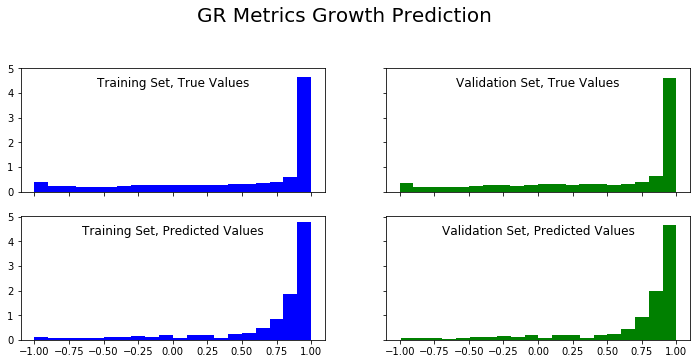

In [404]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

axes[0][0].hist(y['train'], bins=20, density=True, color='b')
axes[0][0].set_title('Training Set, True Values', y=.8)

axes[0][1].hist(y['dev'], bins=20, density=True, color='g')
axes[0][1].set_title('Validation Set, True Values', y=.8)

axes[1][0].hist((norm.cdf(p_train)-.5)*2, bins=20, density=True, color='b')
axes[1][0].set_title('Training Set, Predicted Values', y=.8)

axes[1][1].hist((norm.cdf(p_dev)-.5)*2, bins=20, density=True, color='g')
axes[1][1].set_title('Validation Set, Predicted Values', y=.8)

plt.show()